# pySCENIC workflow - results
4.10.23, 50 runs

-------------------------

In [2]:
from glob import glob
from os.path import basename, normpath
import pandas as pd
import pickle
import os

In [15]:
results_dir_glob = "/Users/danabarilan/Documents/forMasters/Intenship/code/devo-grn/results/results_041023/run_*/"
results_dir = "/Users/danabarilan/Documents/forMasters/Intenship/code/devo-grn/results/results_041023/"

In [ ]:
if not os.path.exists("./figures/"):
    os.mkdir("./figures")

In [16]:
n_runs=50

For each run:
* convert regulons.pkl to csv
* add size column for each regulon

In [ ]:
for folder in glob(results_dir_glob):  # get a list of all sub directories
    with open(folder+'regulons.pkl', 'rb') as f: 
        regulon = pickle.load(f)
    # run = basename(normpath(folder))
    # print(run)
        # get regulon results from pkl file to df and save as csv - for readability
        reg_df = pd.DataFrame({
            'TF': [reg.transcription_factor for reg in regulon],
            'genes': [list(reg.genes) for reg in regulon],
            'score': [reg.score for reg in regulon]
        })
        reg_df['size'] = reg_df['genes'].apply(lambda x: len(x))
        reg_df = reg_df.set_index('TF')
        reg_df.to_csv(folder + 'regulons.csv')

--------------------

## Collect consistent results
TFs and genes that appear in >80% of the runs (40)

In [ ]:
from collections import Counter

In [ ]:
tfs_counter = Counter()
for folder in glob(results_dir_glob):
    regulons_df = pd.read_csv(folder+'regulons.csv', index_col=0)
    tfs_counter.update(regulons_df.index)

In [ ]:
tfs_counter

plot TFs count distrubution

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tfs_counts_series = pd.Series(tfs_counter).sort_values(ascending=False)  # sorted Series of TFs counts 

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxenplot(tfs_counts_series, ax=ax_box)
sns.histplot(tfs_counts_series, ax=ax_hist, bins=n_runs)
sns.despine(ax=ax_box, left=True)
plt.axvline(int(n_runs*0.8), color='red')
plt.savefig("./figures/tfs_counts.png")

In [ ]:
tfs_80 = tfs_counts_series[tfs_counts_series > n_runs*0.8]
len(tfs_80)

## Genes

save for each run the consistent regulons

In [ ]:
for folder in glob(results_dir_glob):
    regulons_df = pd.read_csv(folder+'regulons.csv', index_col=0)
    regulons_top_freq = regulons_df.loc[[tf for tf in regulons_df.index if tf in tfs_80.index]]
    regulons_top_freq.to_csv(folder + 'regulons_top80.csv')

calculate gene counts for the same TF (among top 80% TFs)

In [ ]:
from ast import literal_eval

In [ ]:
all_dfs = pd.concat([pd.read_csv(folder + 'regulons_top80.csv', index_col=0) for folder in glob(results_dir_glob)])
all_dfs_genes = all_dfs['genes']  # keep only genes column, discard size of regulon and score
all_dfs_genes = all_dfs_genes.apply(literal_eval) # convert string to list of genes
all_dfs_genes = all_dfs_genes.explode()  # convert to couples of TF-gene
all_dfs_genes = pd.DataFrame(all_dfs_genes).rename({'genes': 'gene'}, axis='columns') # to dataframe
gene_counts = all_dfs_genes.groupby(['TF', 'gene']).size().to_frame('count') # count couples fo TF - gene
gene_counts.to_csv(results_dir+"gene_counts.csv") # save to csv 

In [ ]:
gene_counts = gene_counts.reset_index()
len(gene_counts.gene.unique())  # number of unique genes

In [ ]:
gene_counts

plot genes counts (from TF-gene couples)

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxenplot(gene_counts['count'], ax=ax_box)
sns.histplot(gene_counts['count'], ax=ax_hist, bins=n_runs)
sns.despine(ax=ax_box, left=True)
plt.axvline(int(n_runs*0.8), color='red')
plt.savefig("./figures/genes_counts.png")

save AUCell score matrix of only top 80% for each run

In [ ]:
for folder in glob(results_dir_glob):
    auc_mtx = pd.read_csv(folder + "AUCell_mat.csv", index_col=0)
    reg_top80 = pd.read_csv(folder + "regulons_top80.csv", index_col=0)
    # keep AUC_mtx TFs that are in reg_top80:
    auc_mtx_top80 = auc_mtx.loc[:, [col for col in auc_mtx if col.strip("(+)") in reg_top80.index.values.tolist()]]
    auc_mtx_top80.to_csv(folder + 'AUCell_mat_top80.csv')

-------

## All regulons Heatmaps with designated legend color

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
types_df = pd.read_csv('../../data/cell_type.csv', index_col=0)

In [22]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("tab20", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danabarilan/opt/miniconda3/envs/devo-grn/lib/python3.10/site-packages/seaborn/matrix.py:654: User

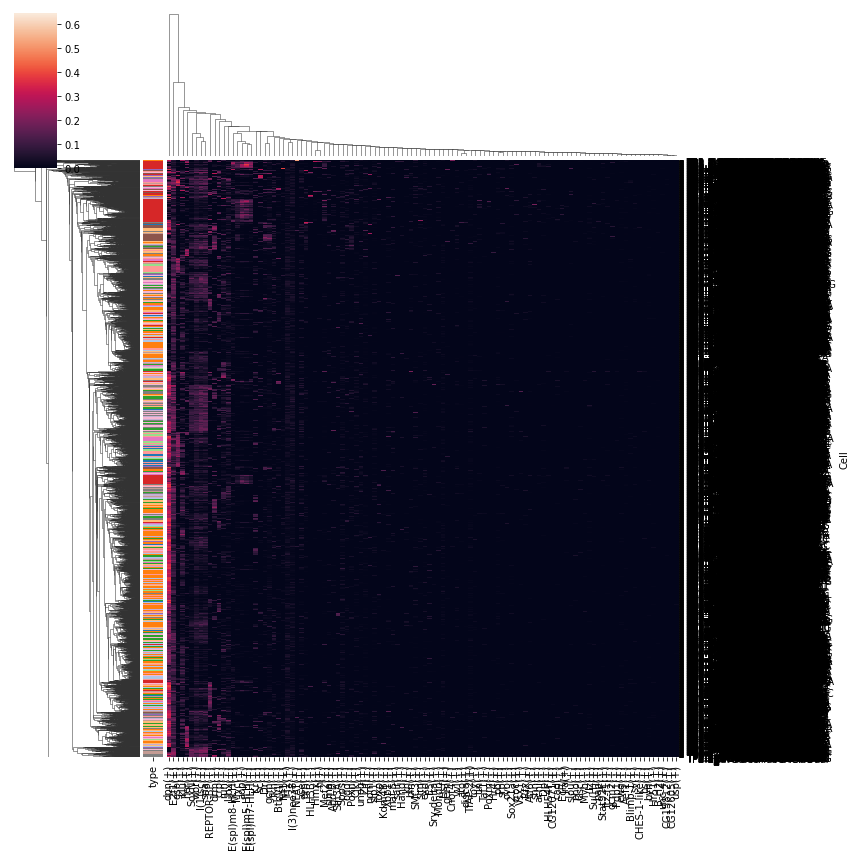

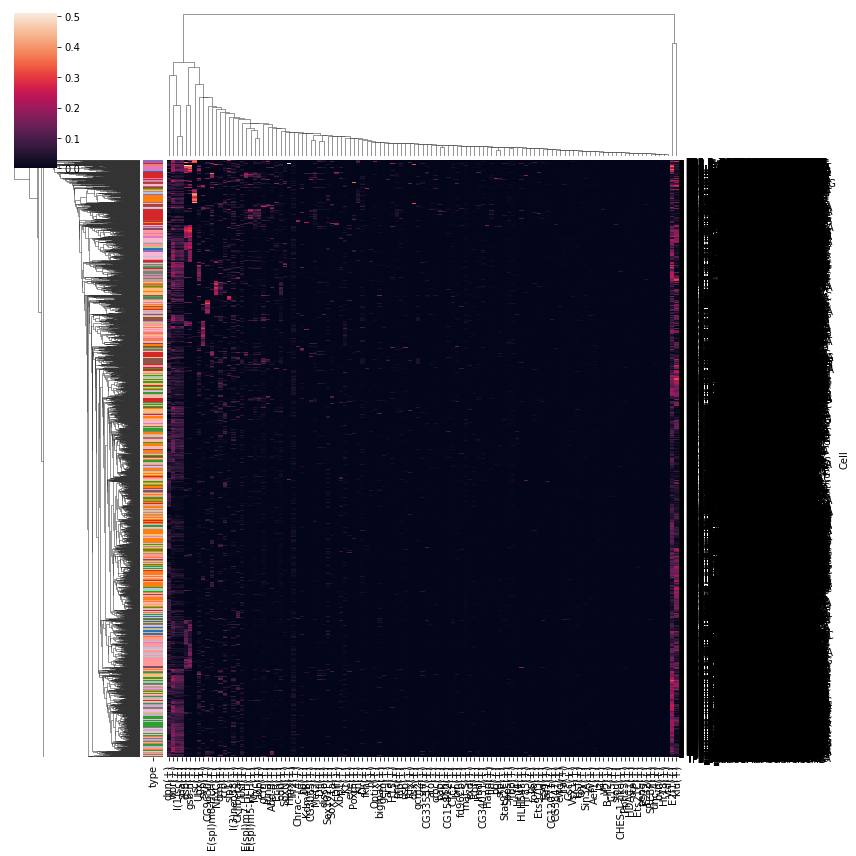

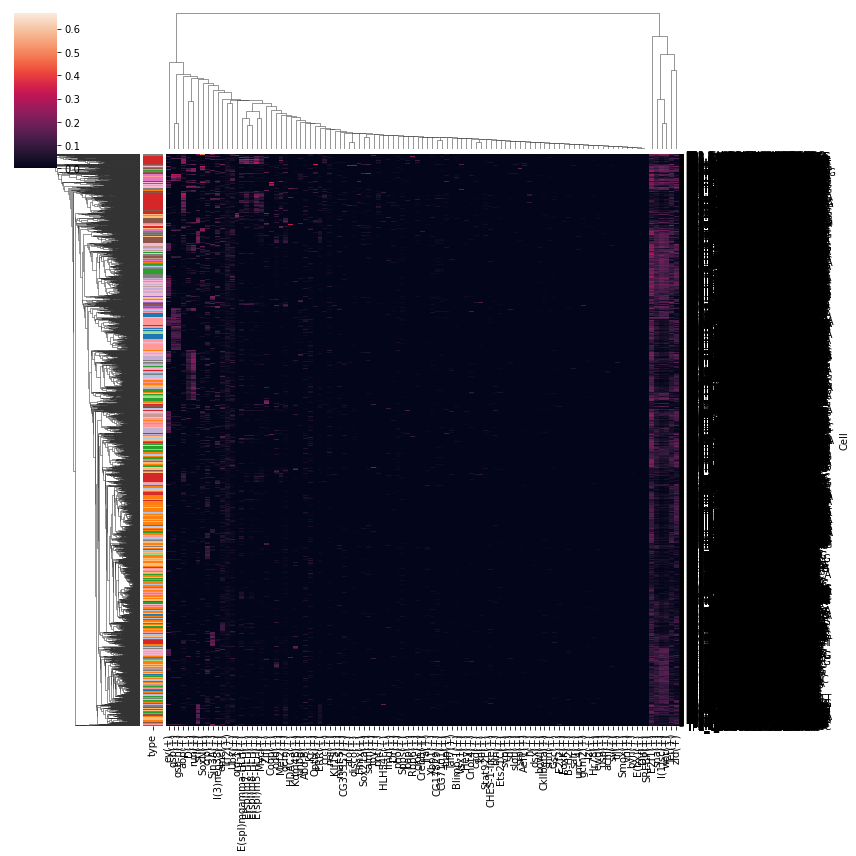

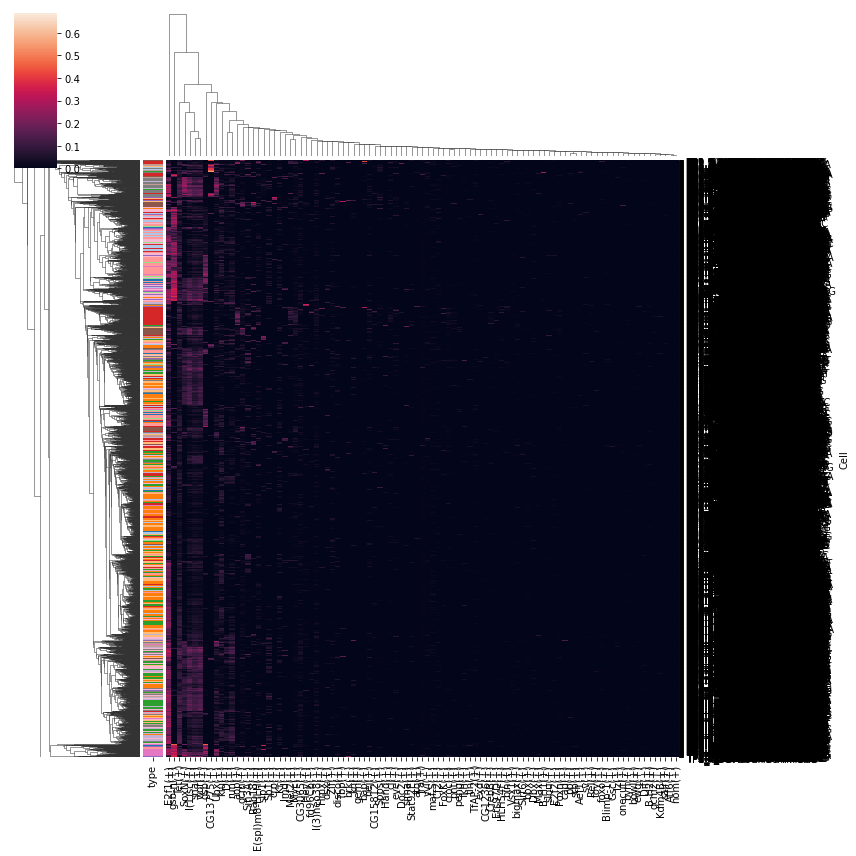

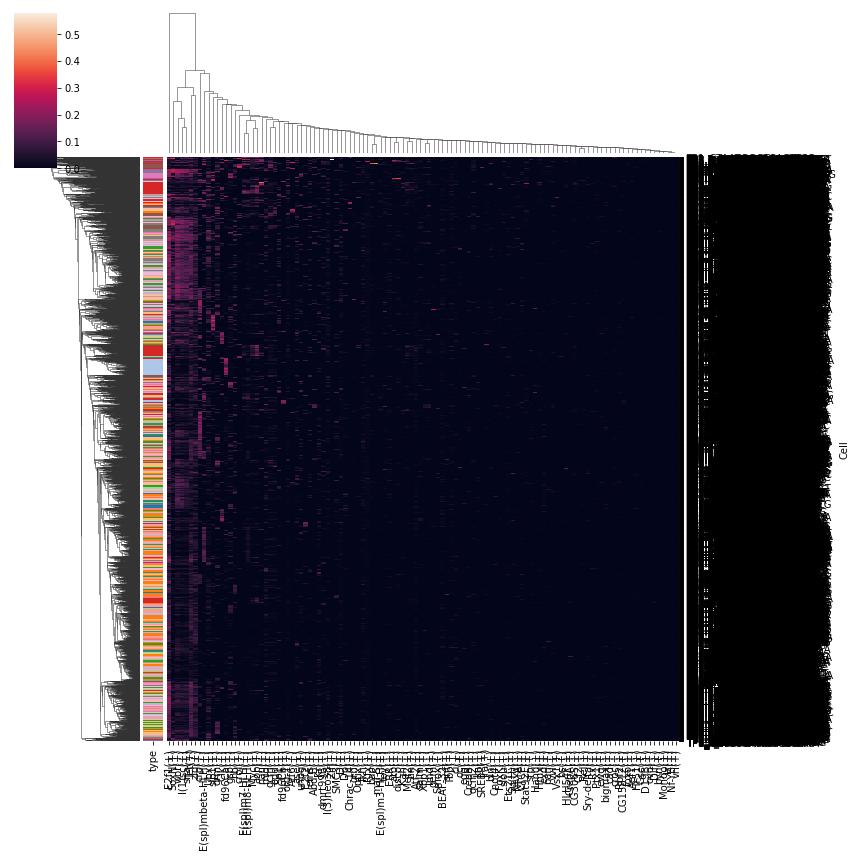

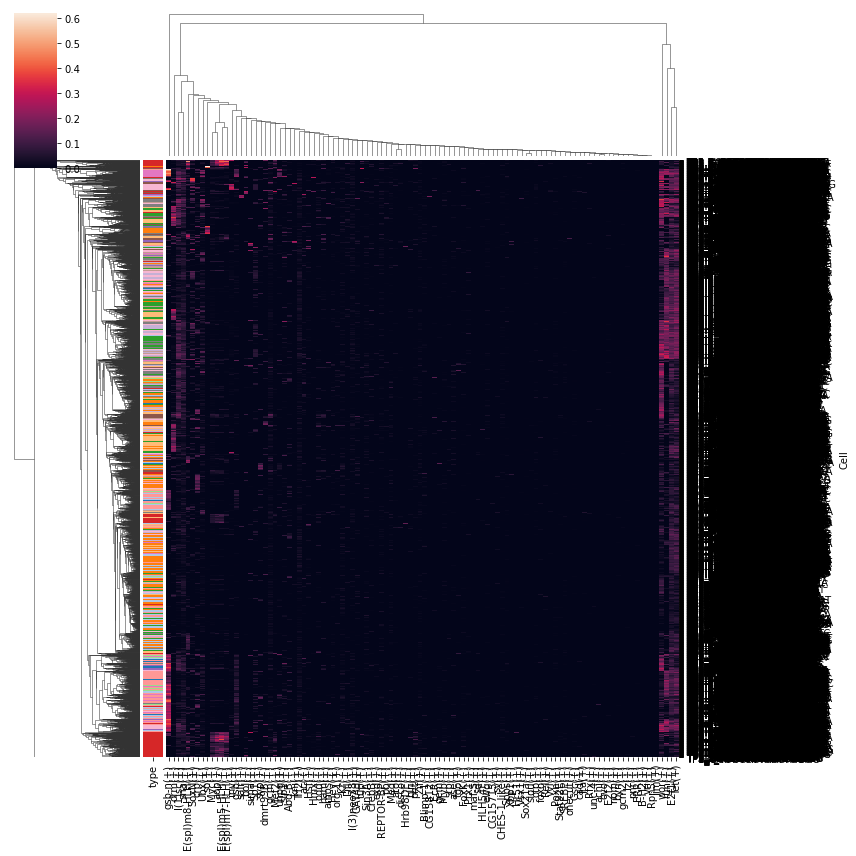

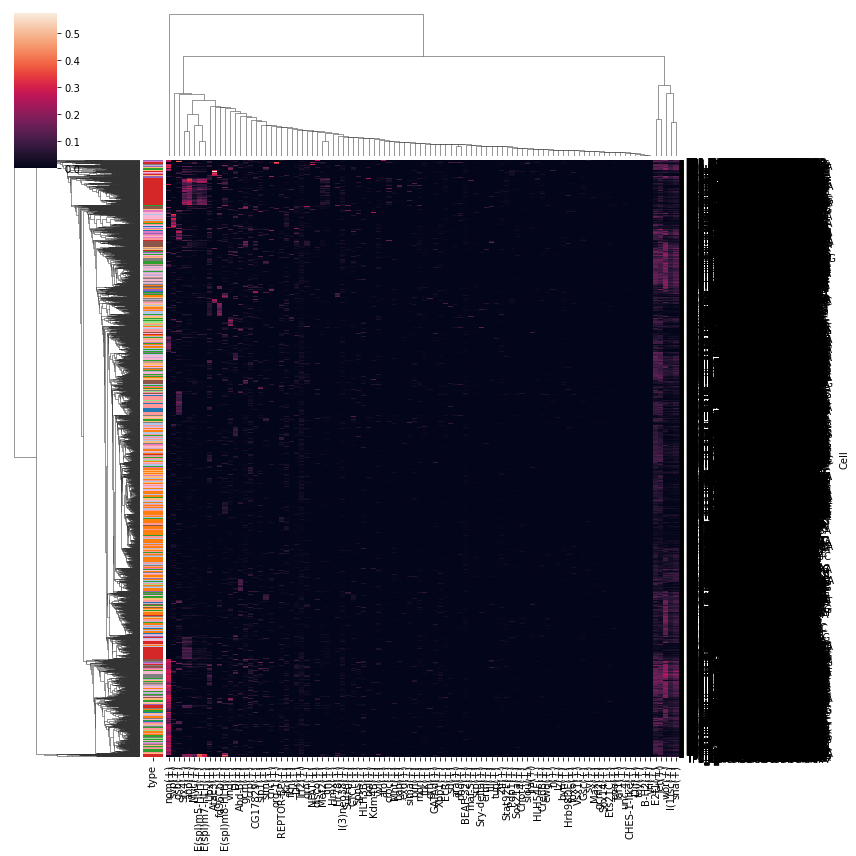

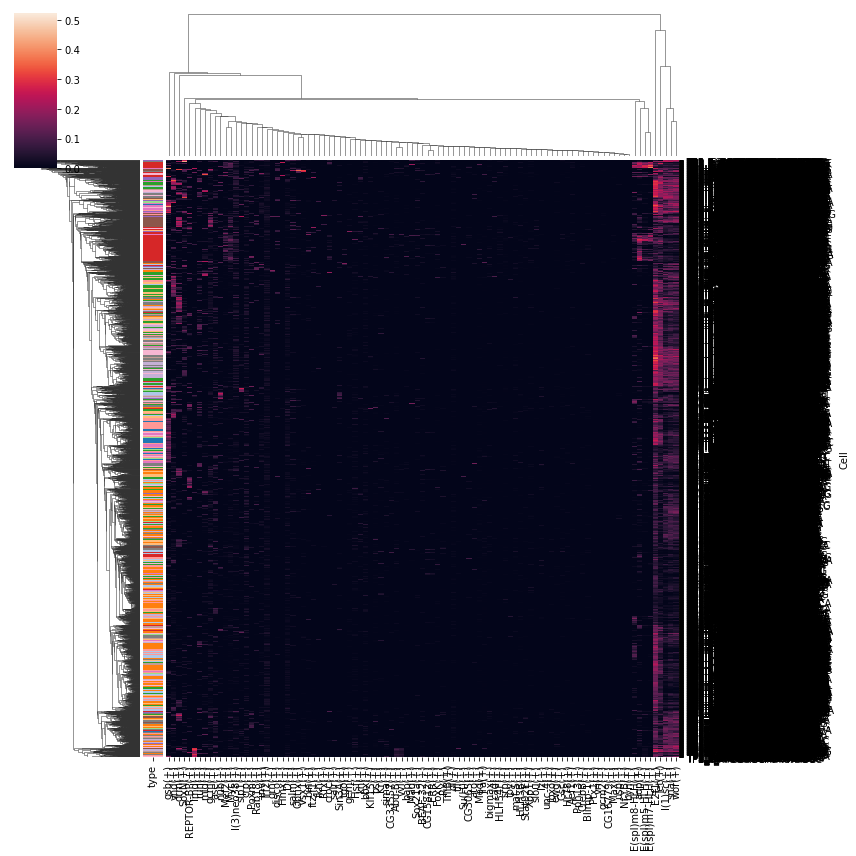

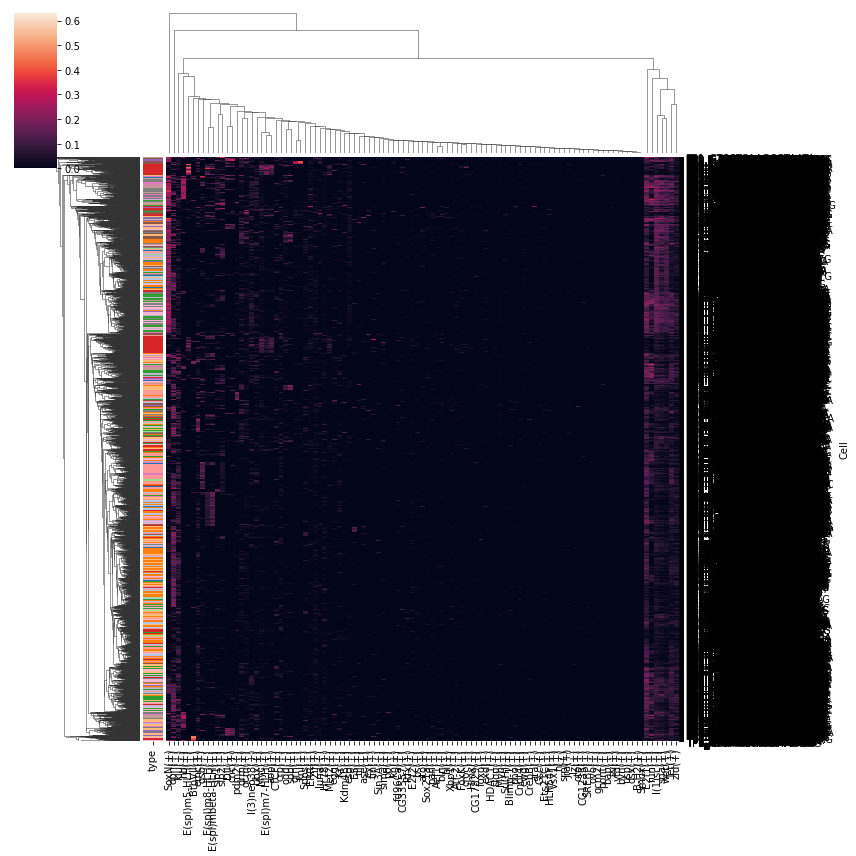

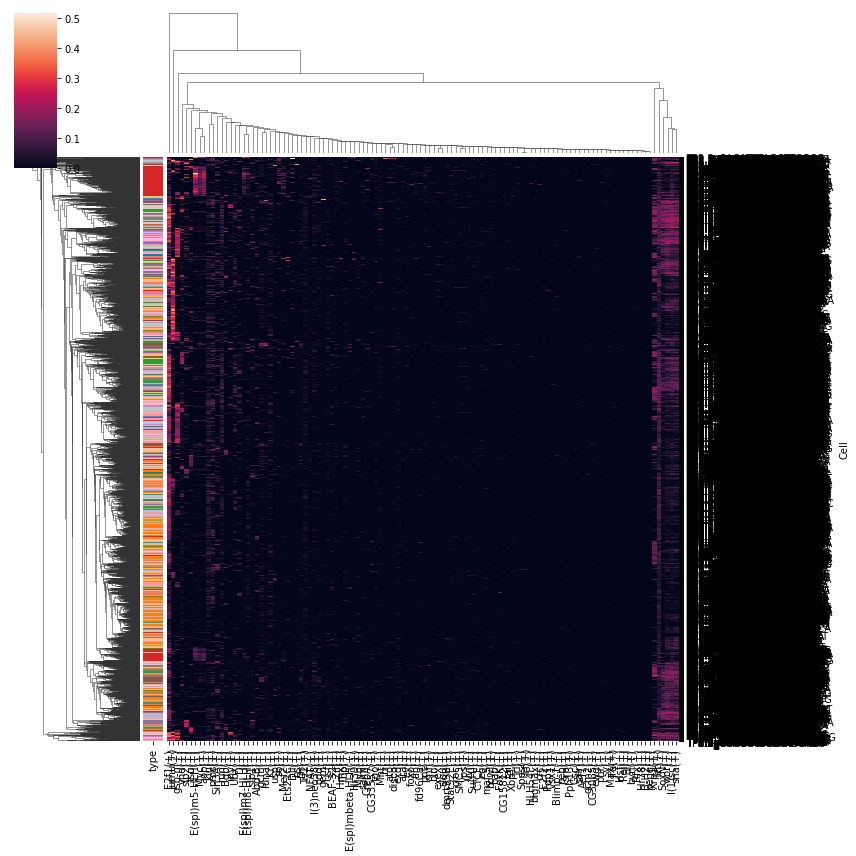

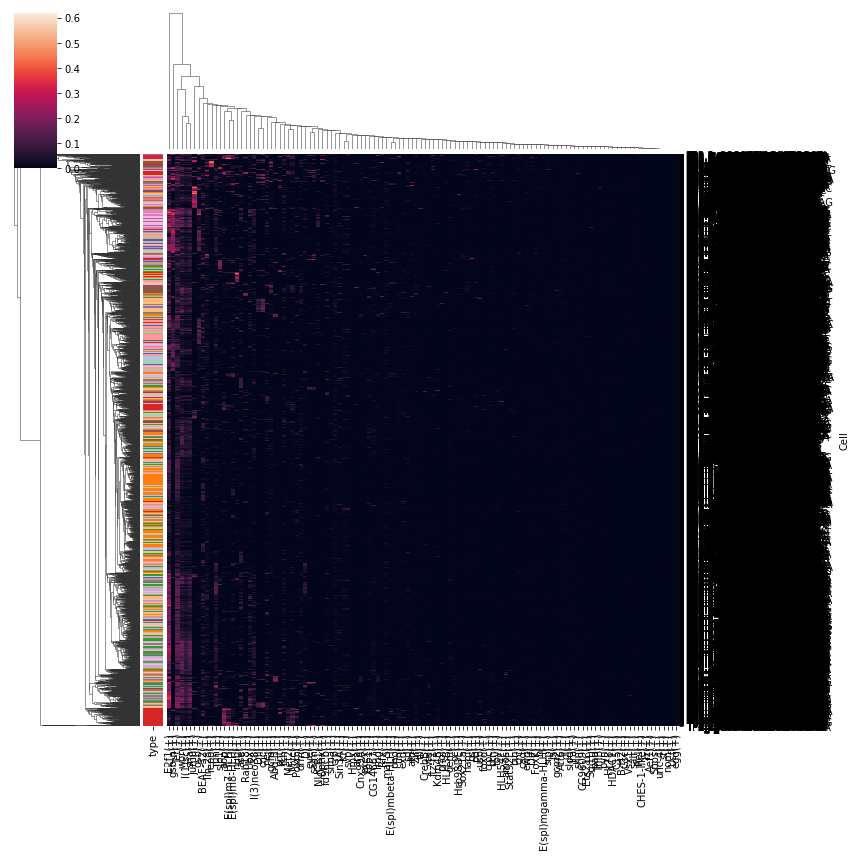

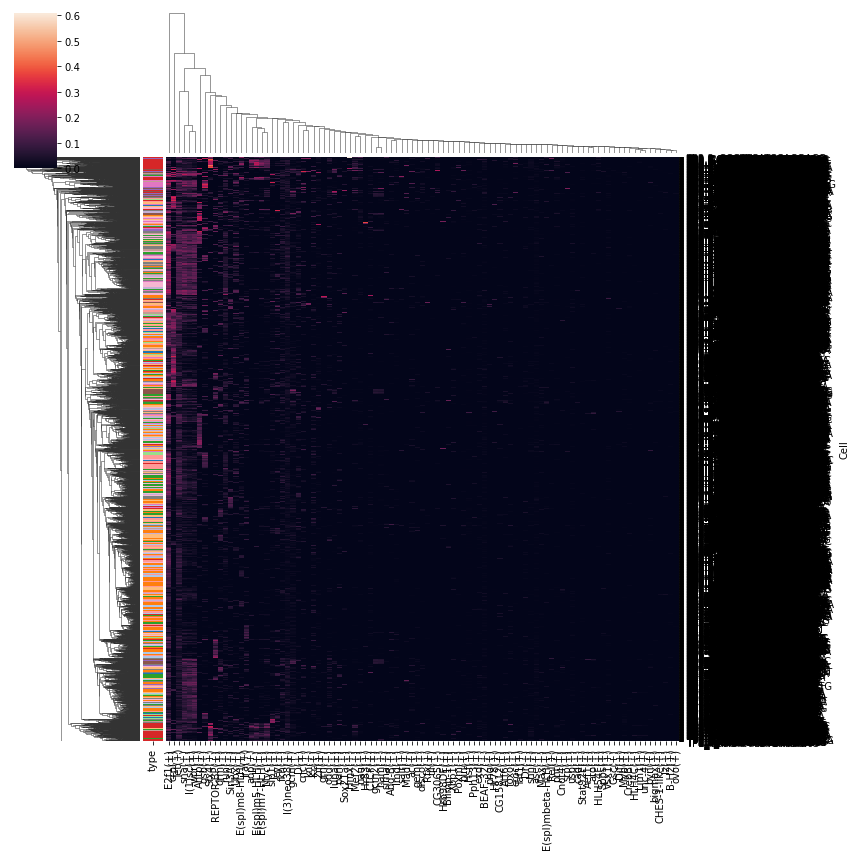

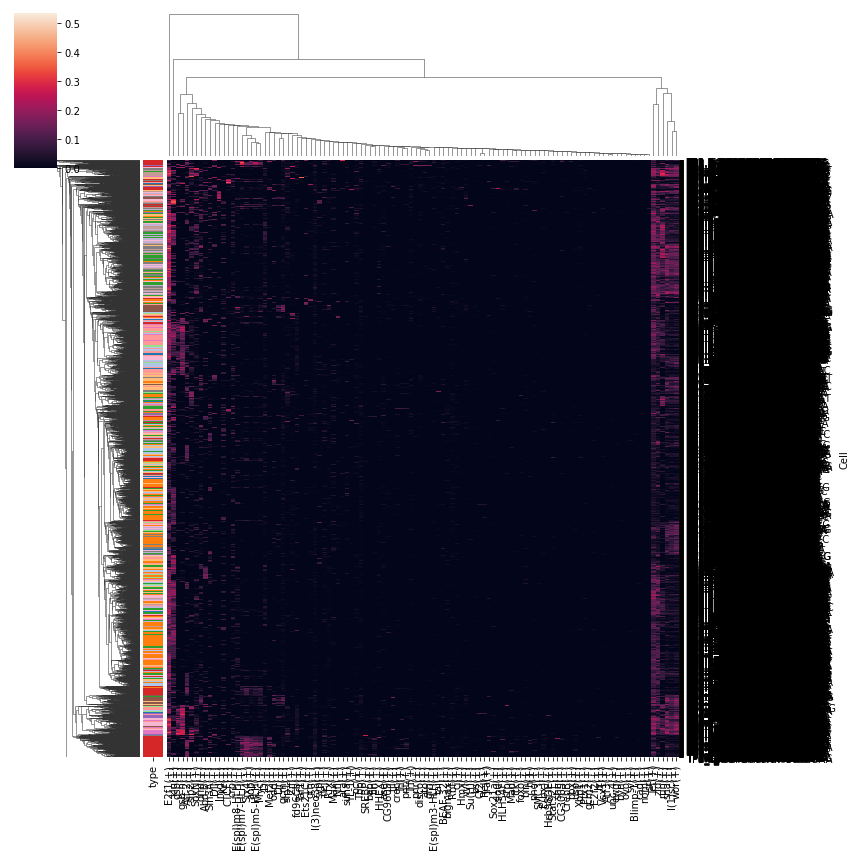

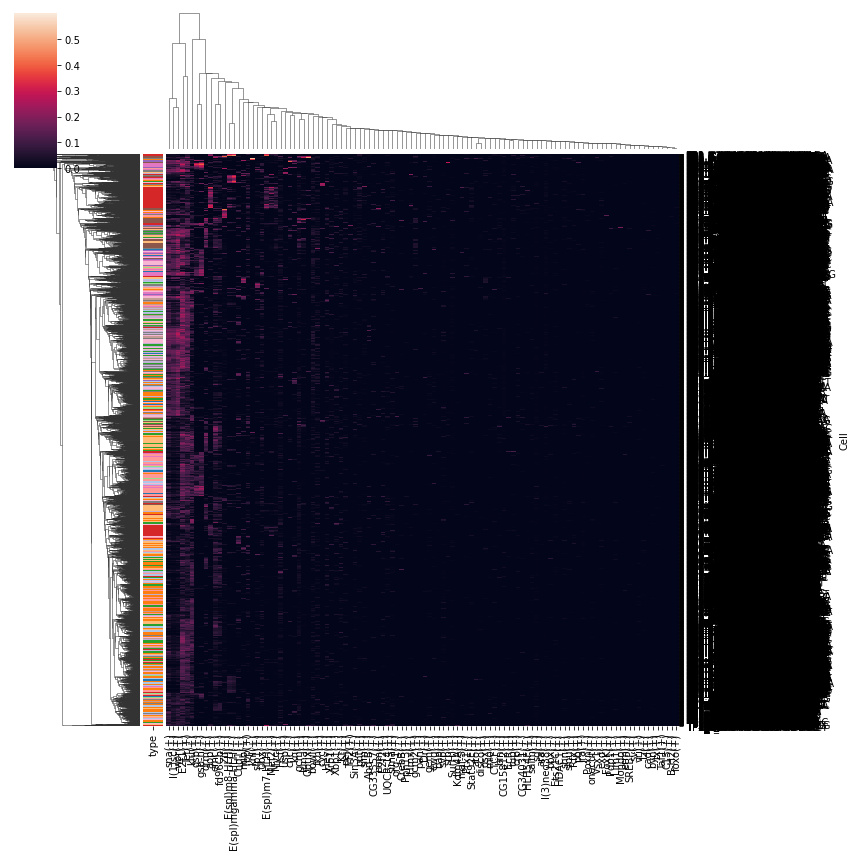

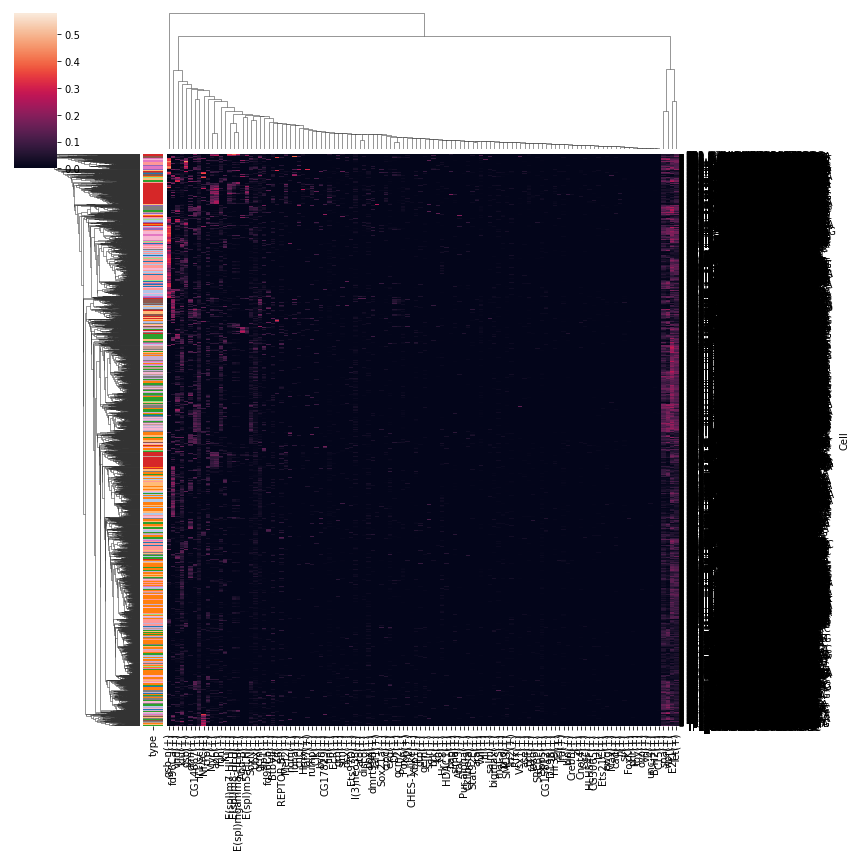

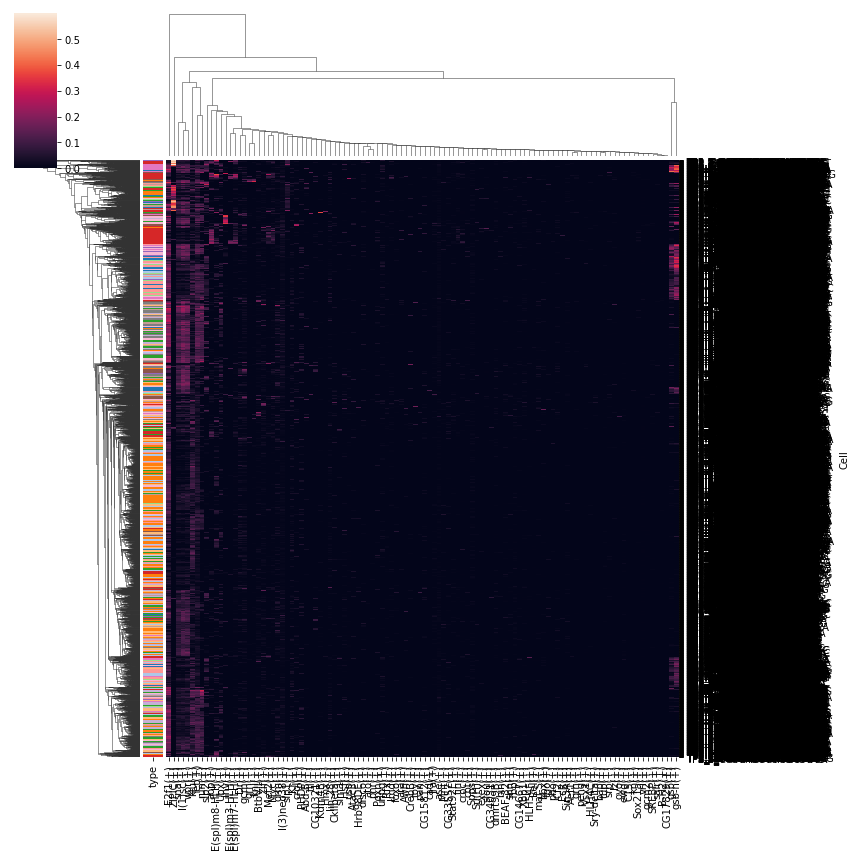

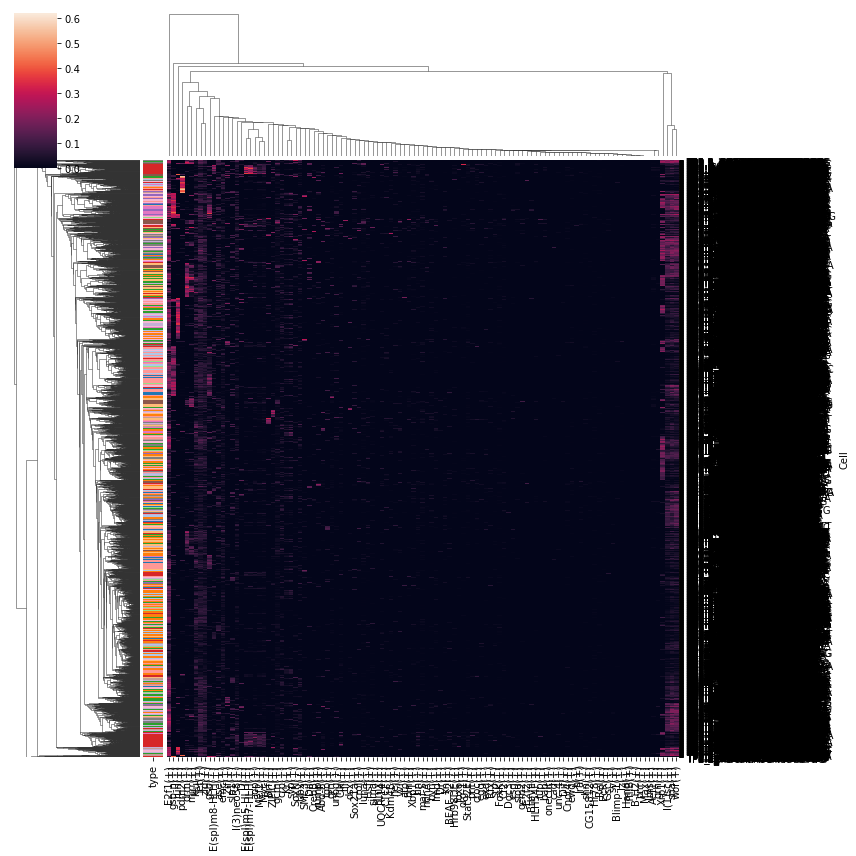

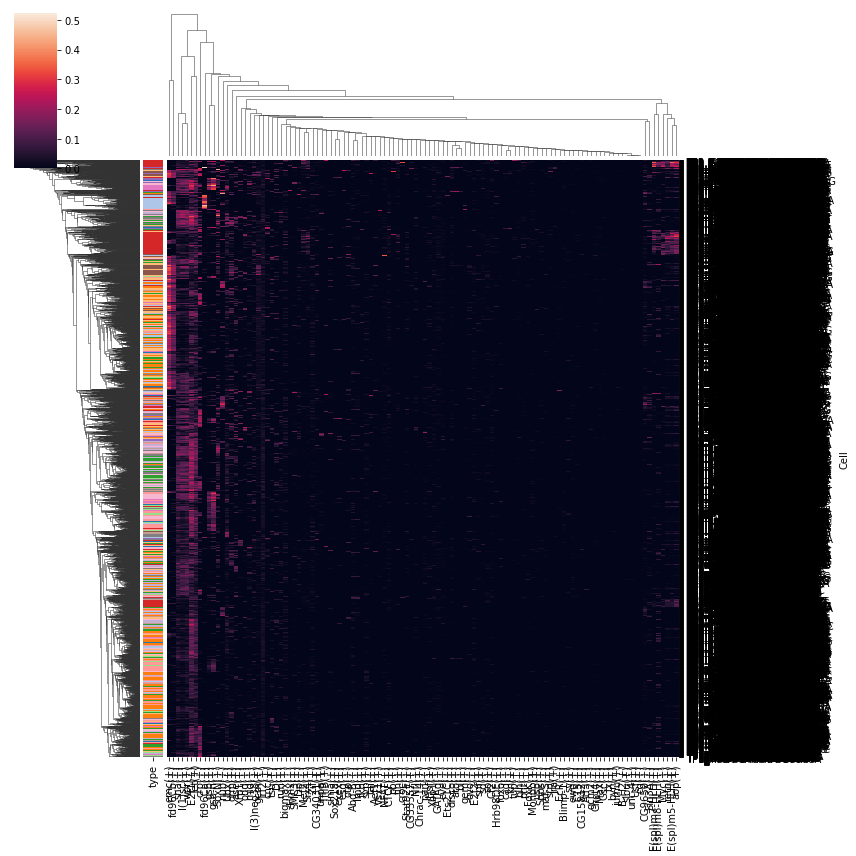

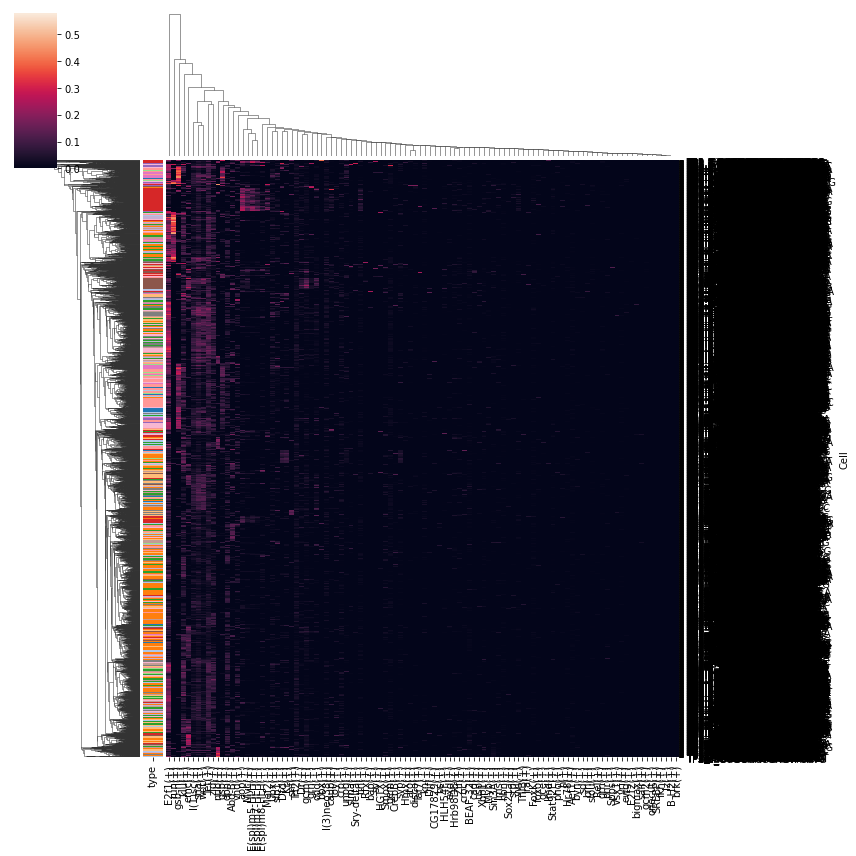

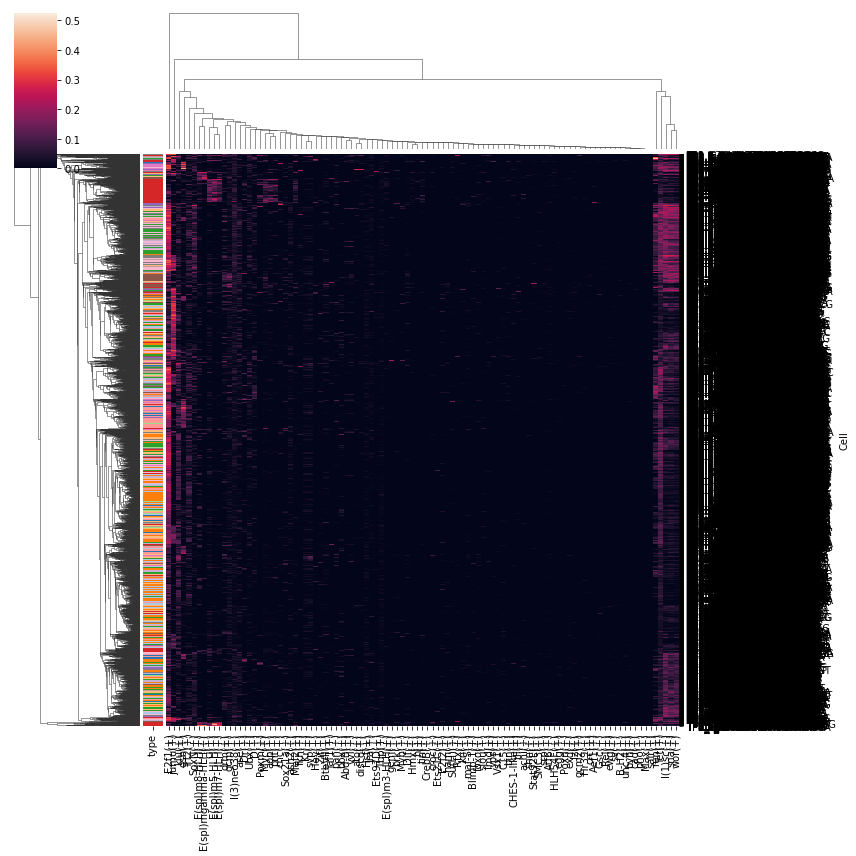

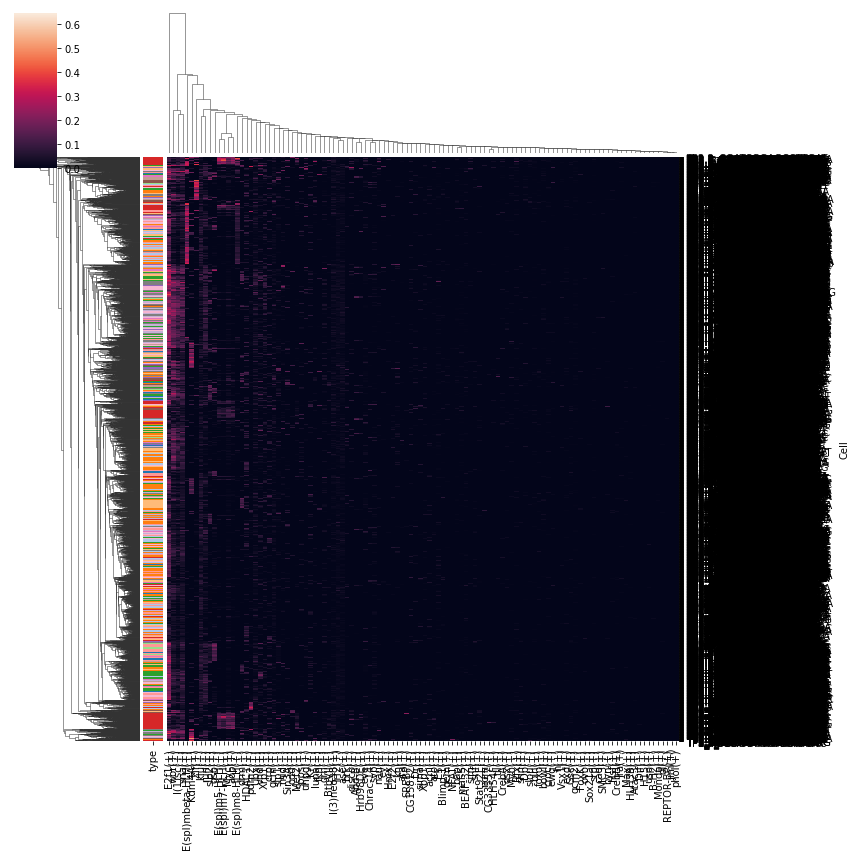

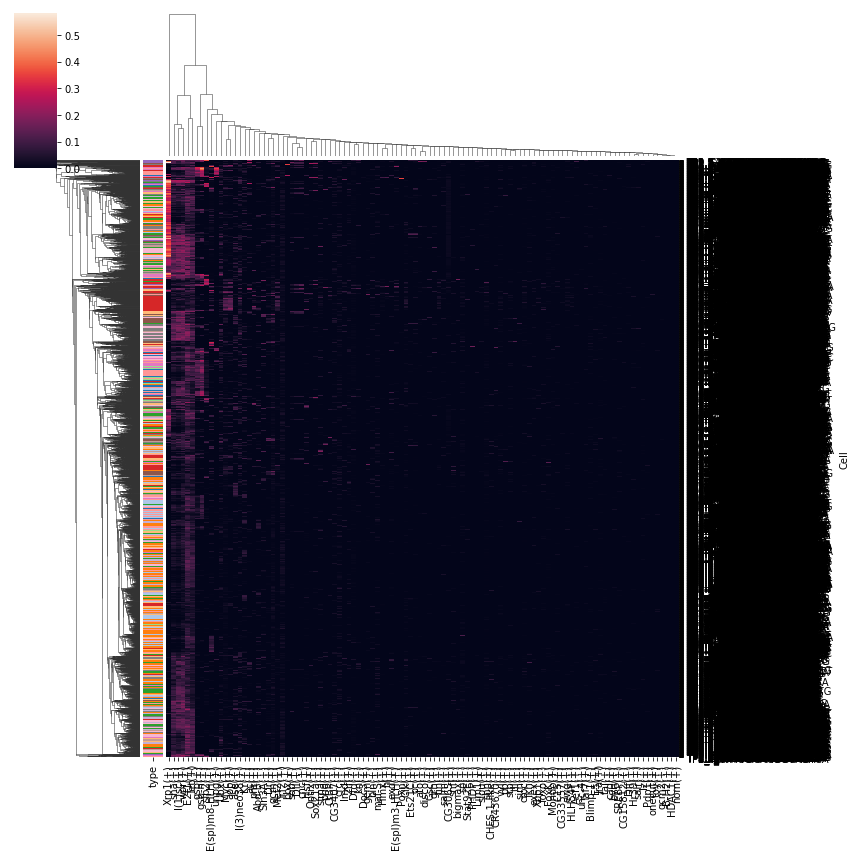

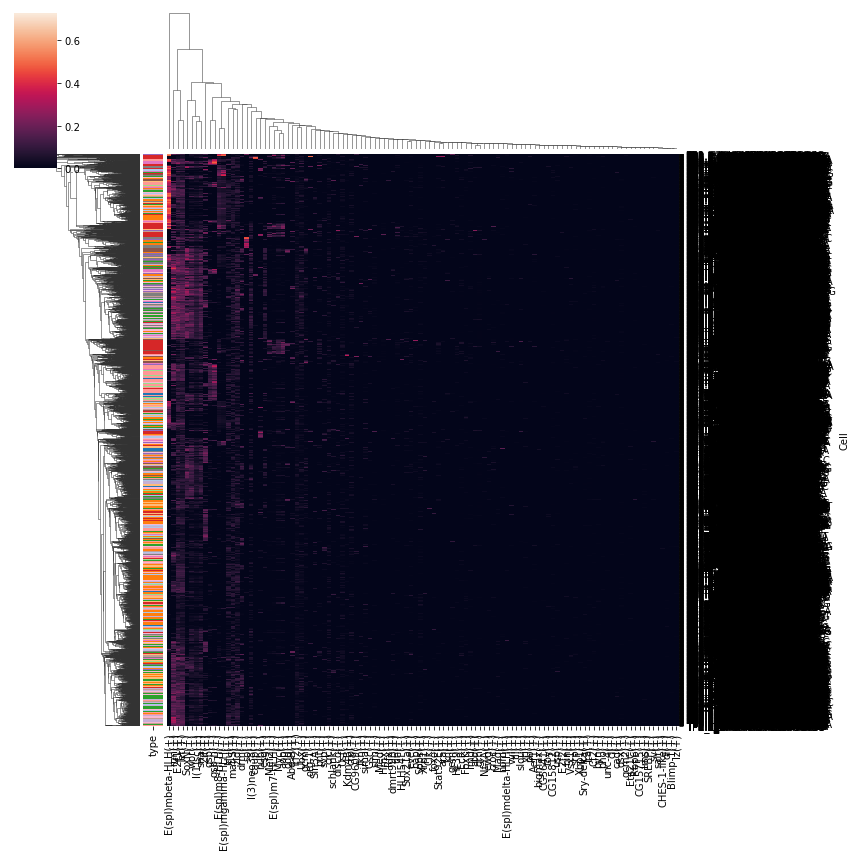

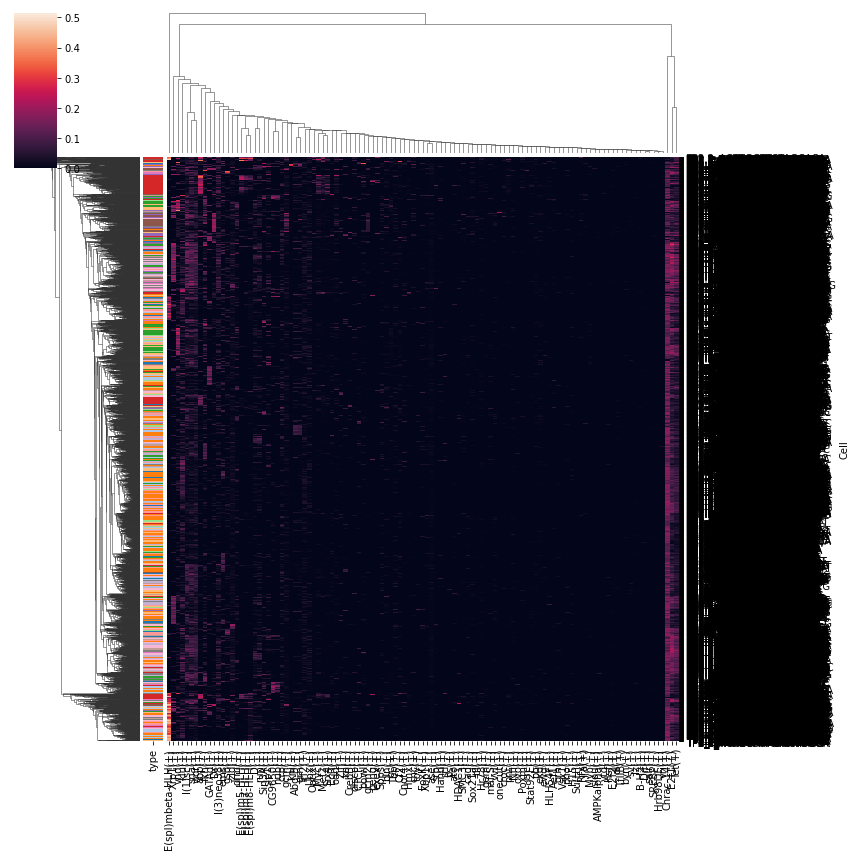

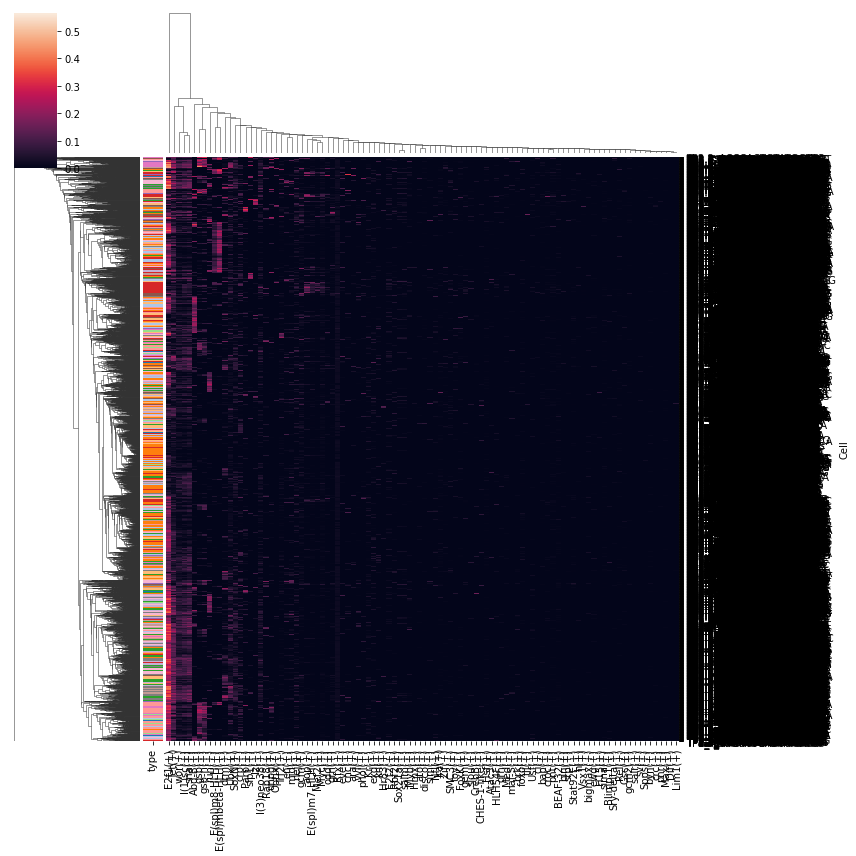

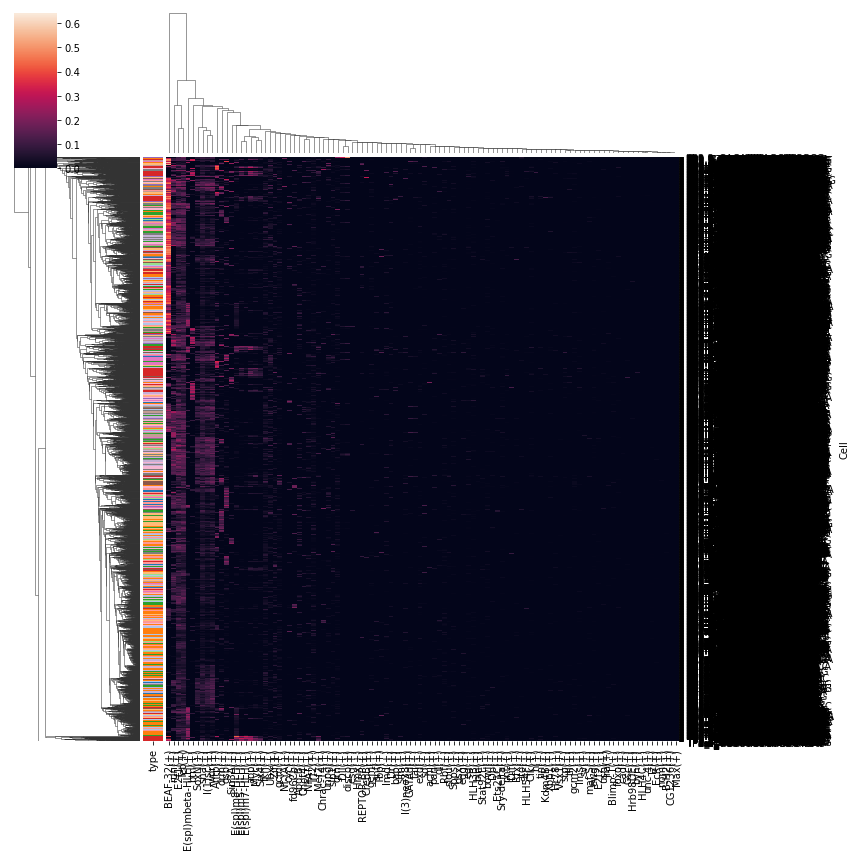

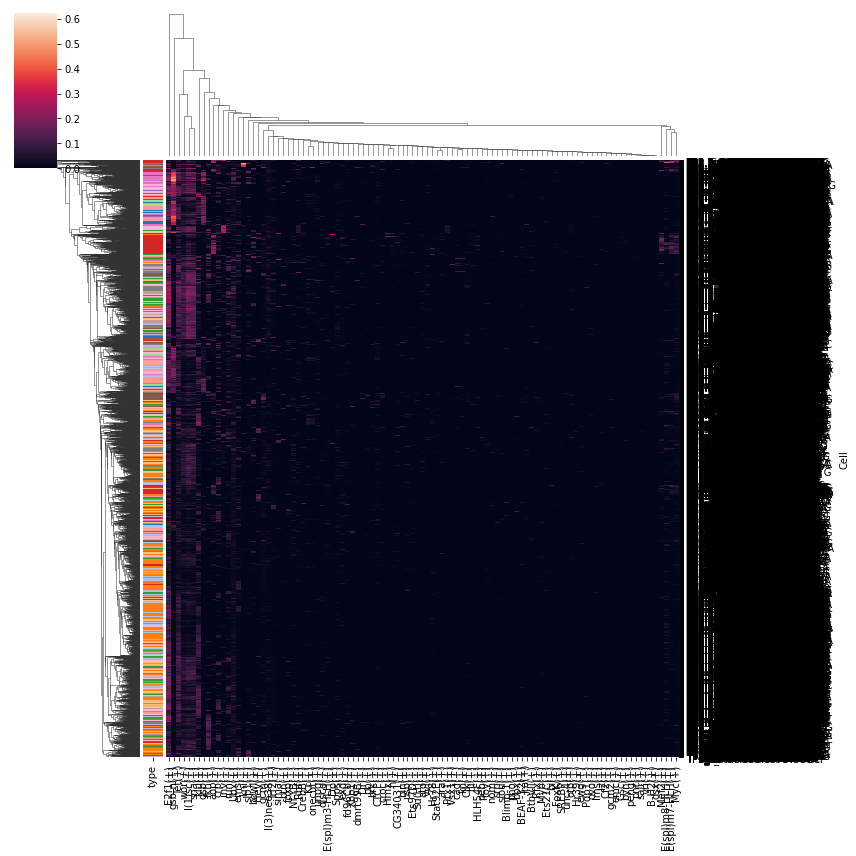

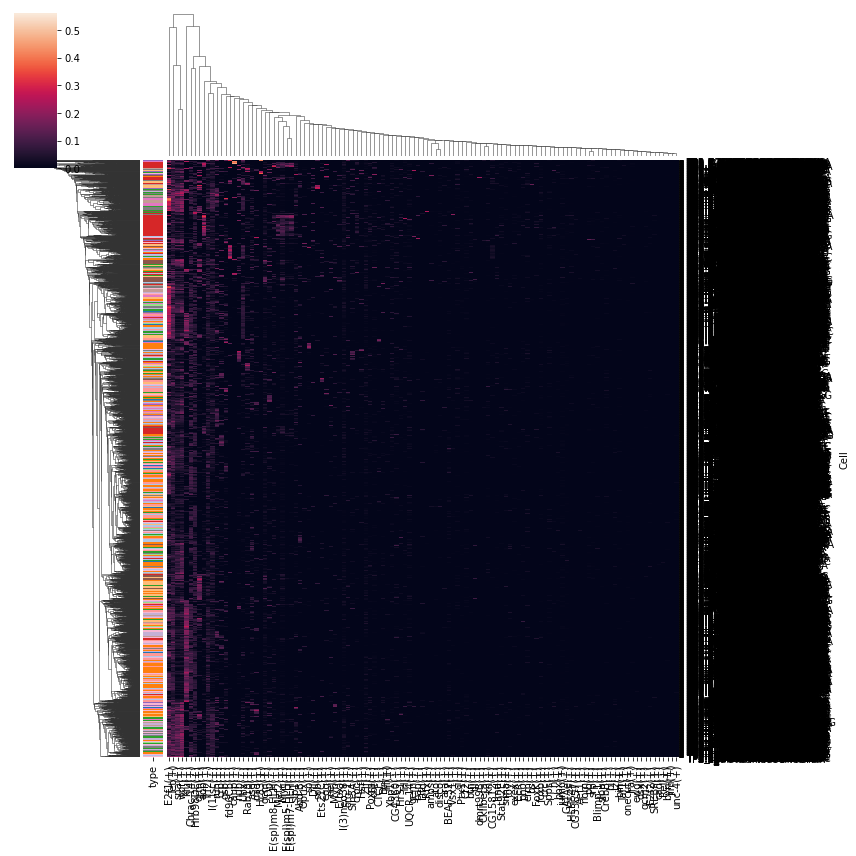

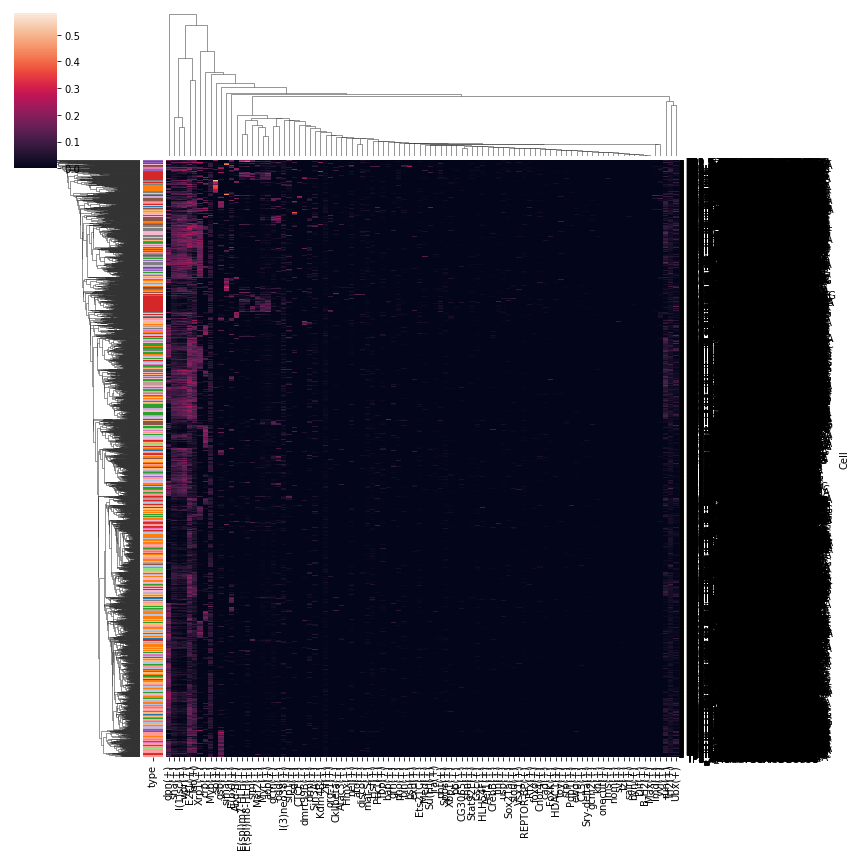

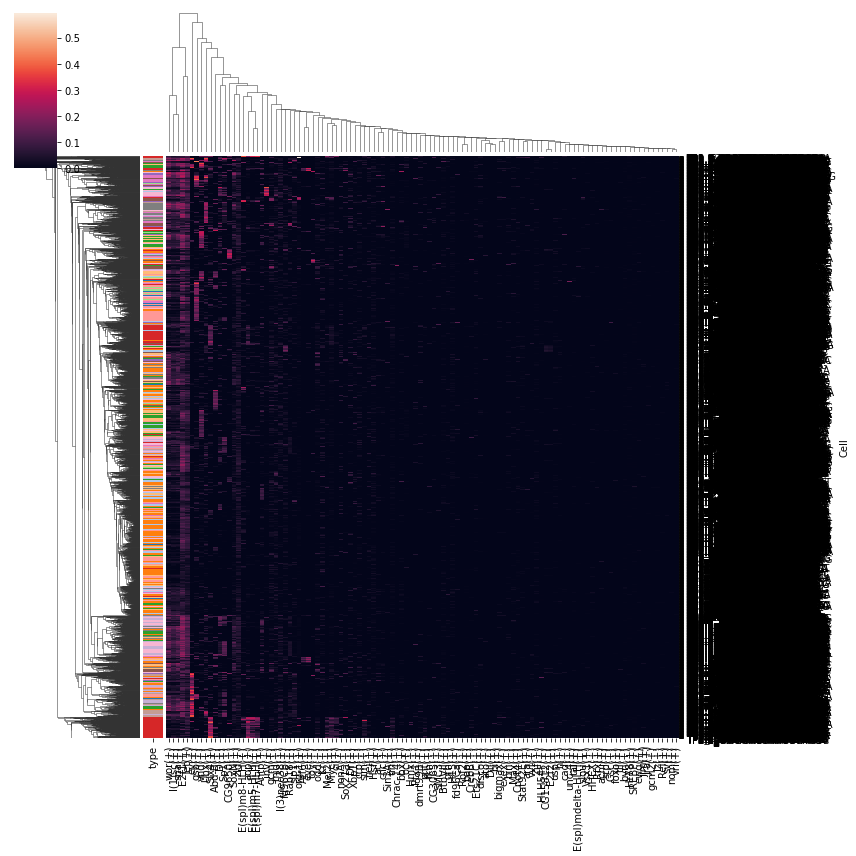

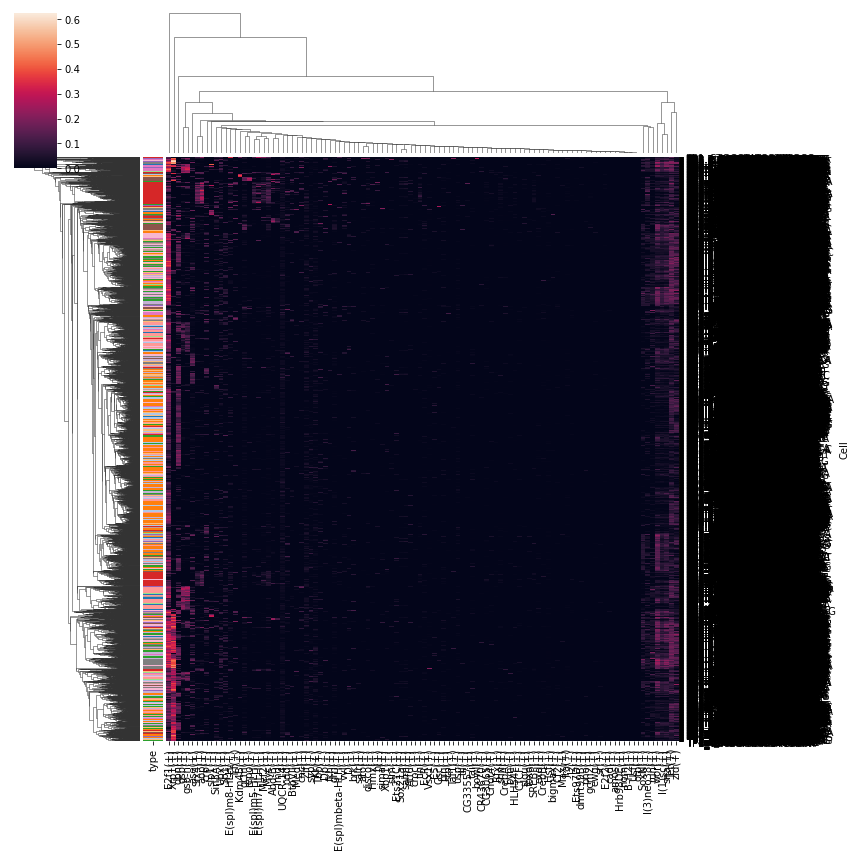

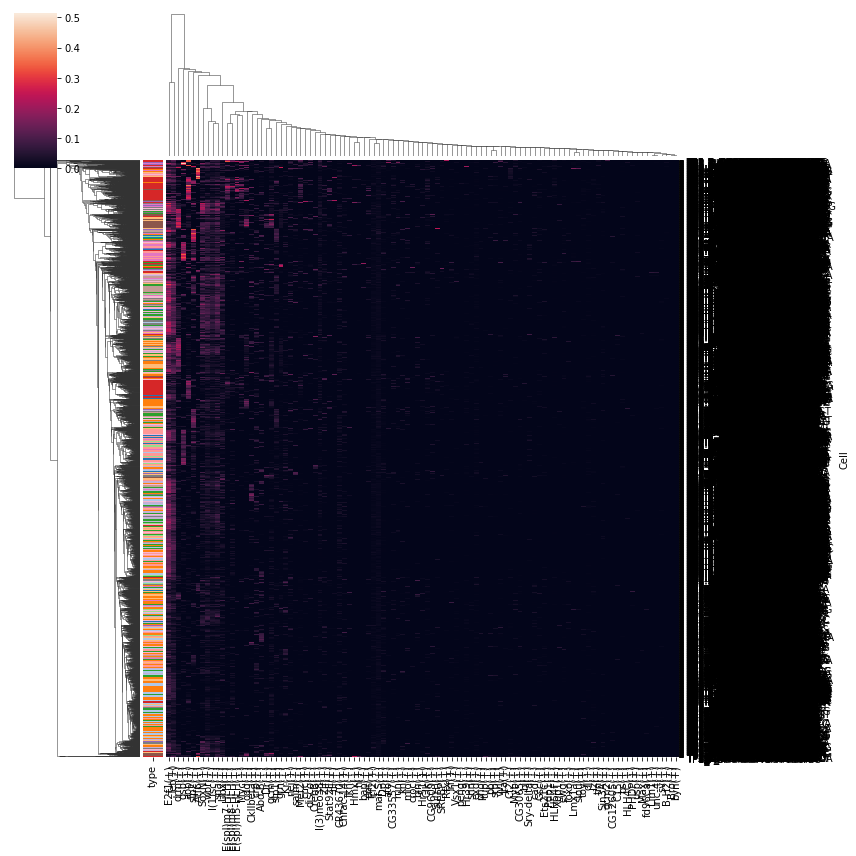

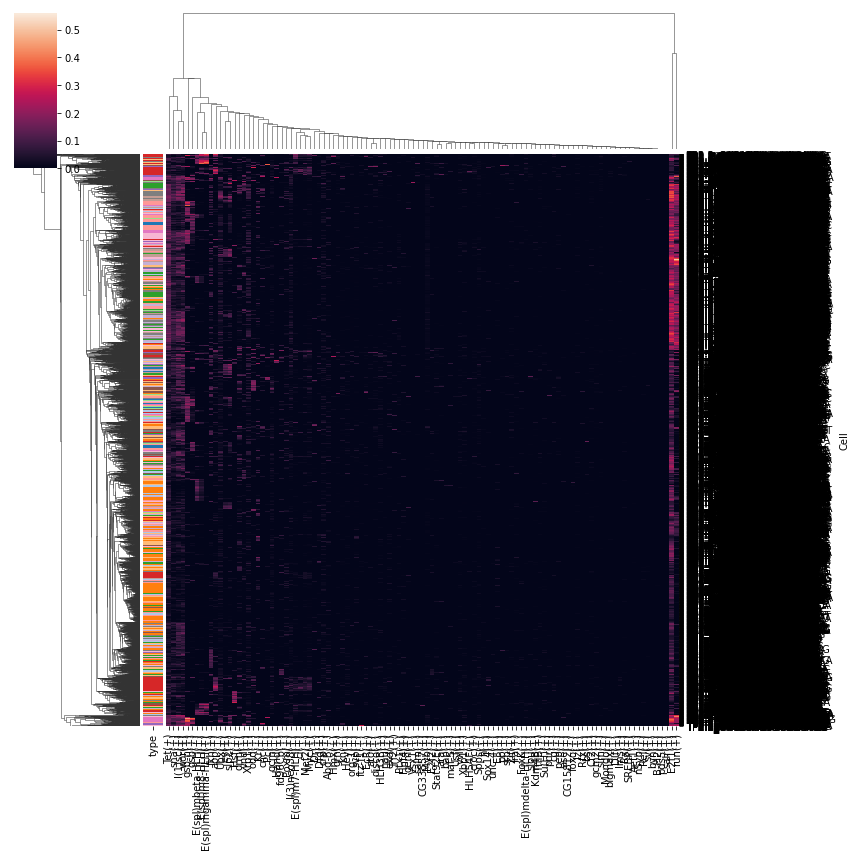

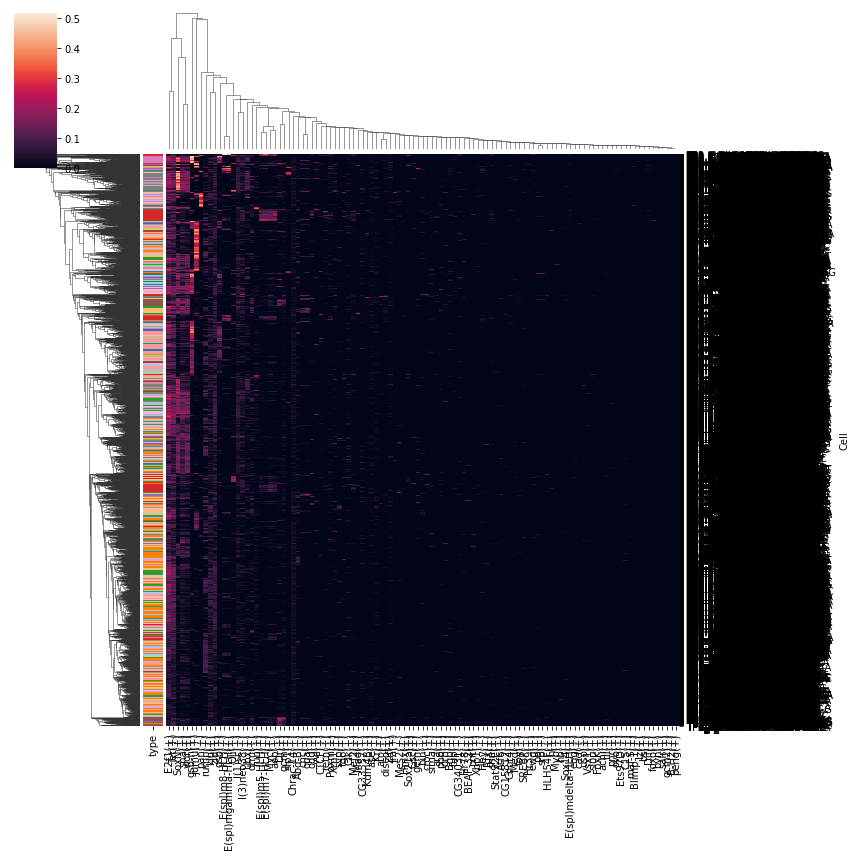

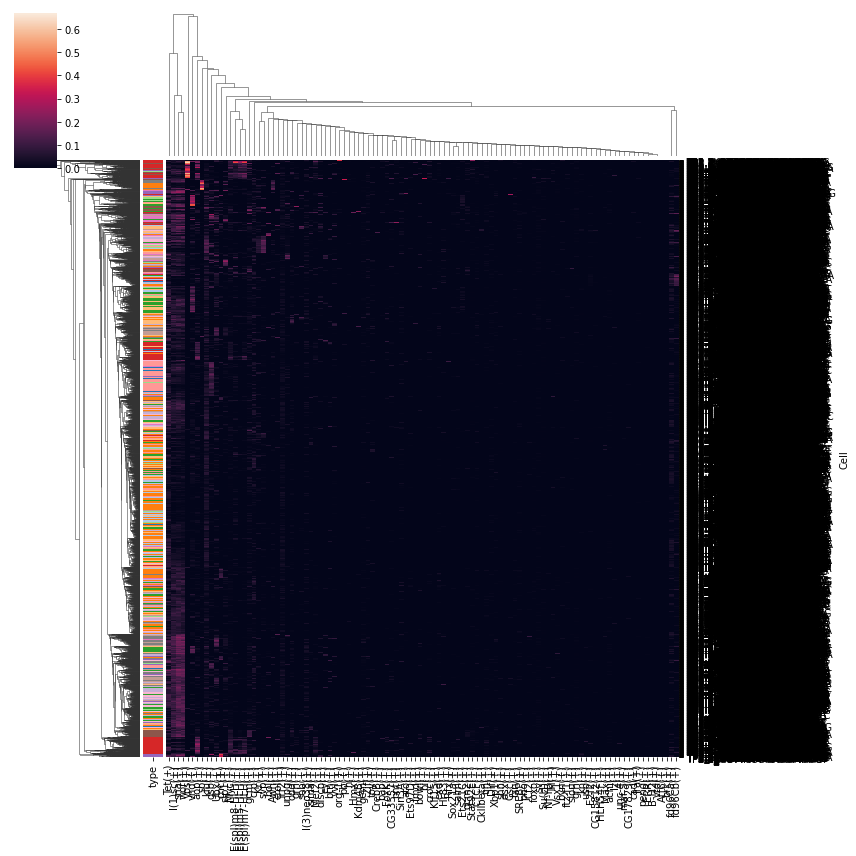

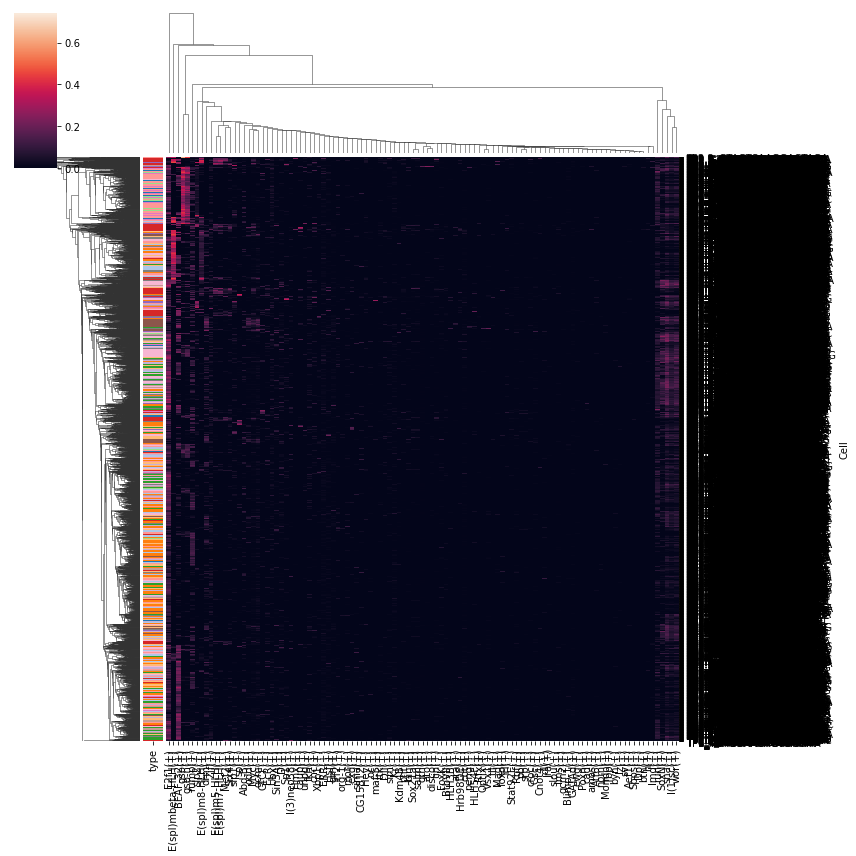

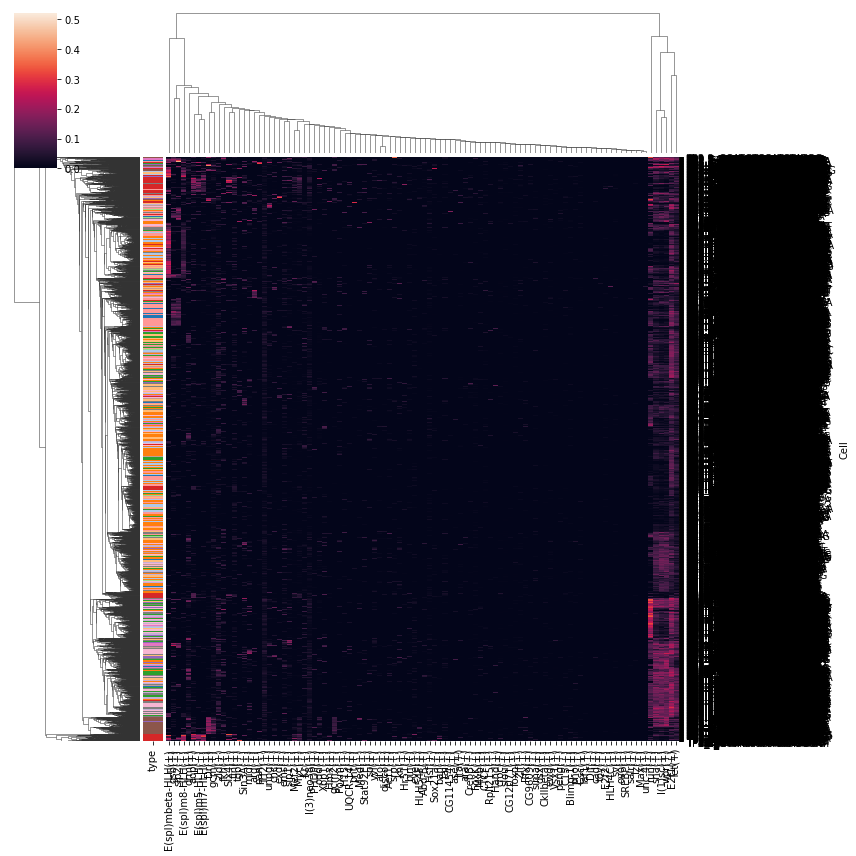

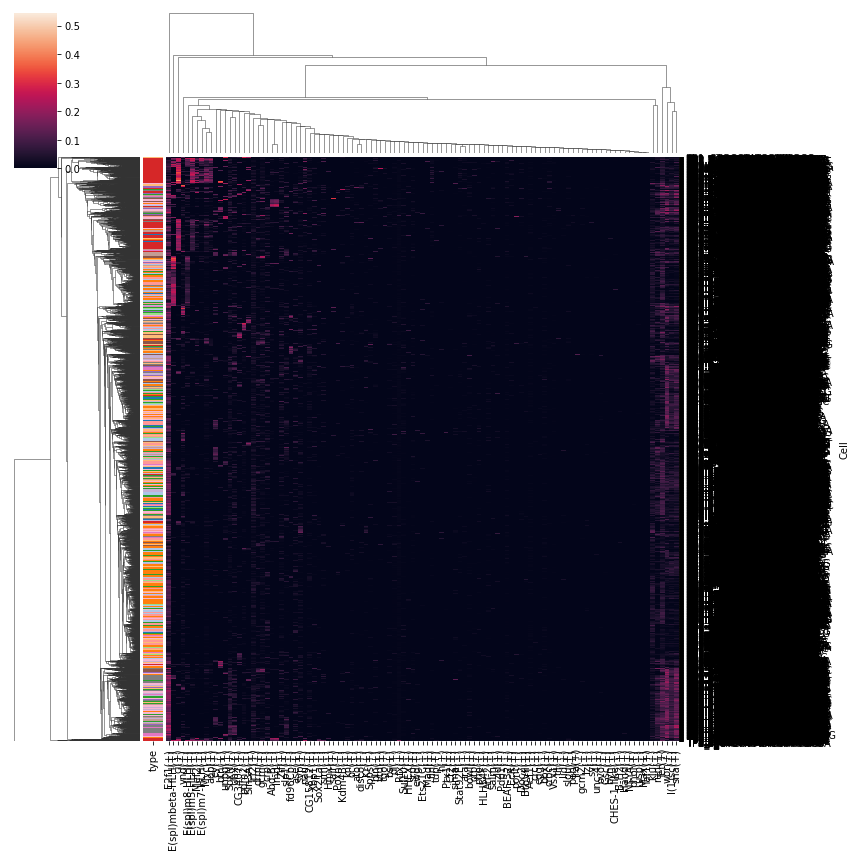

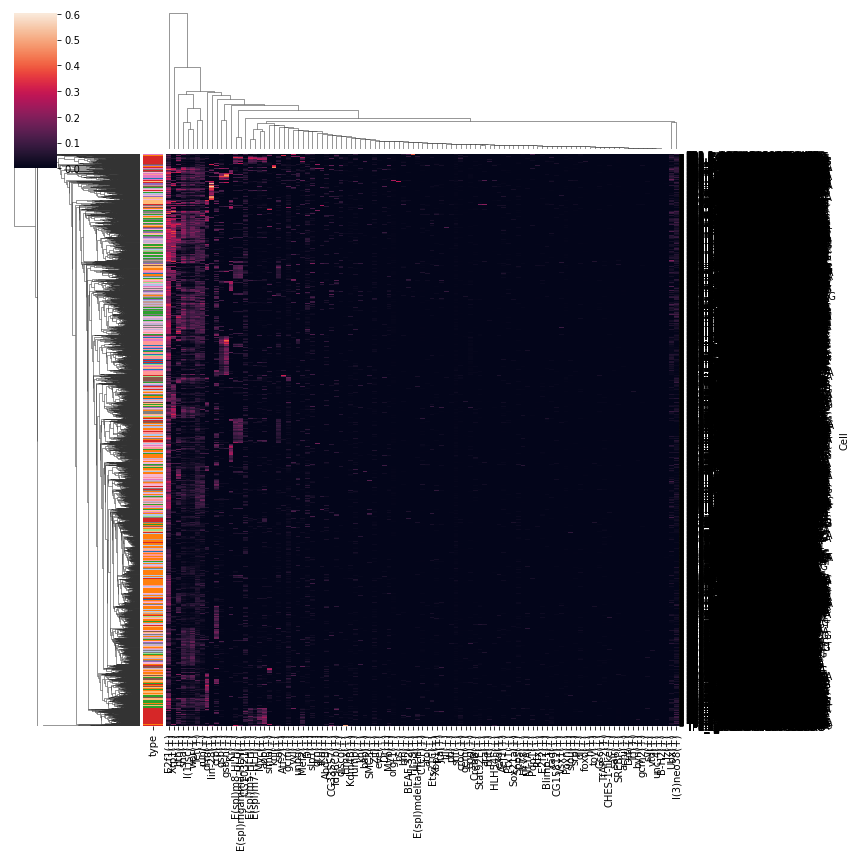

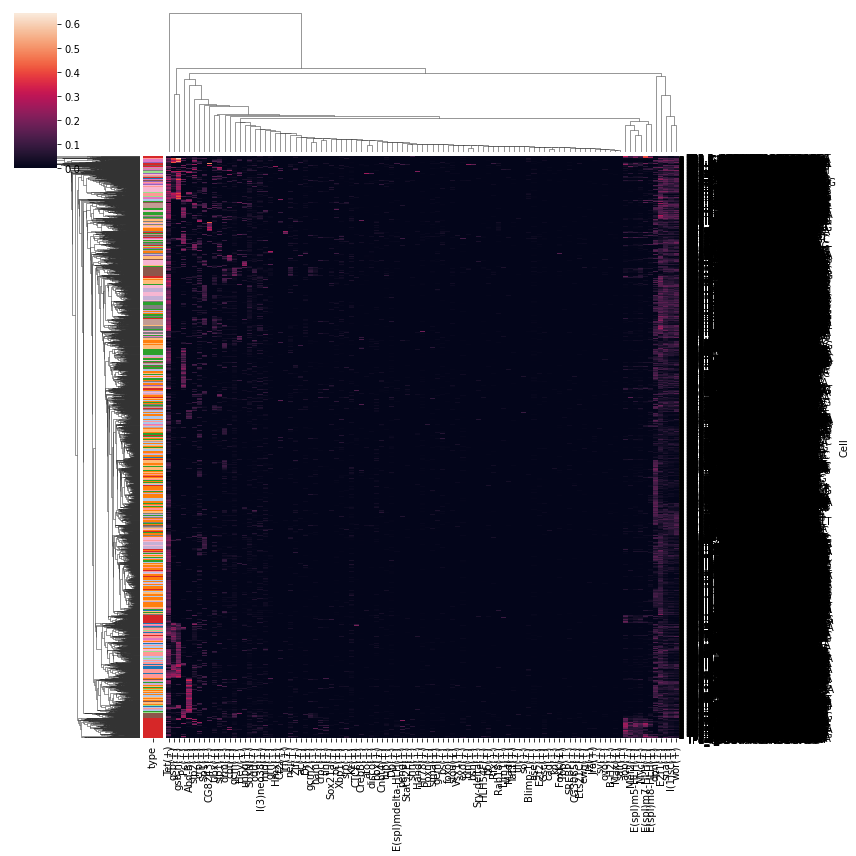

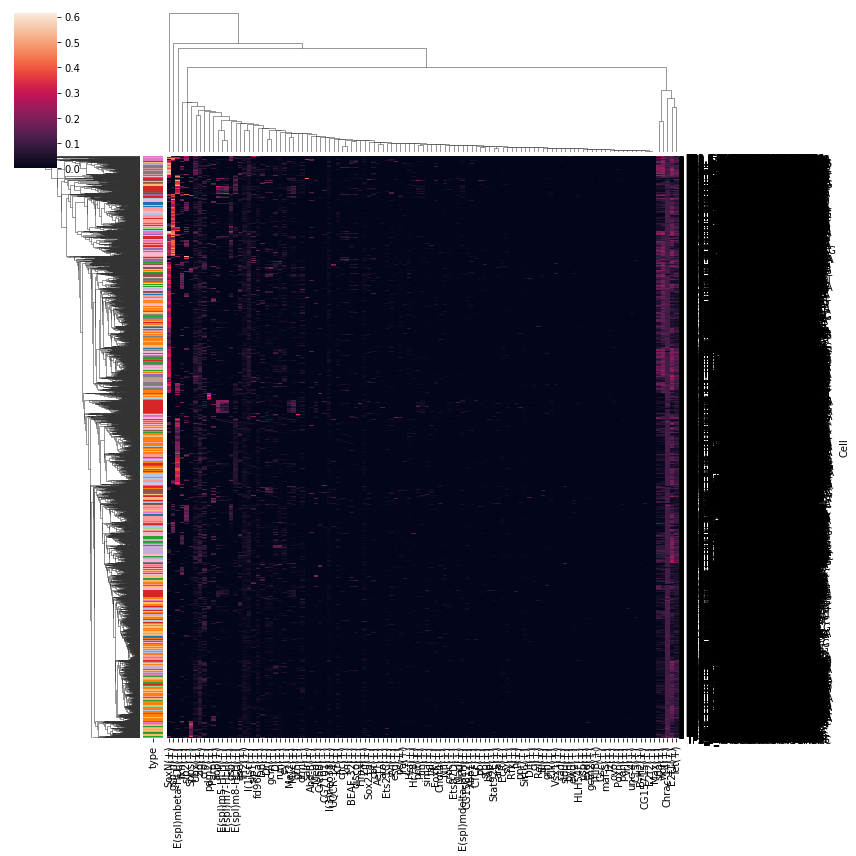

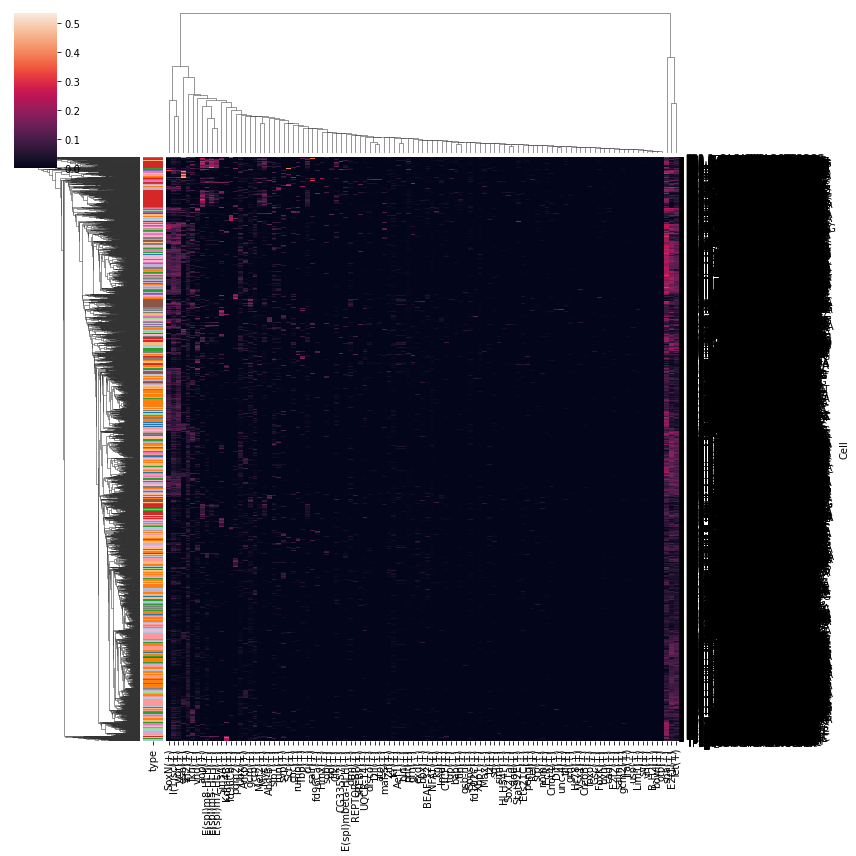

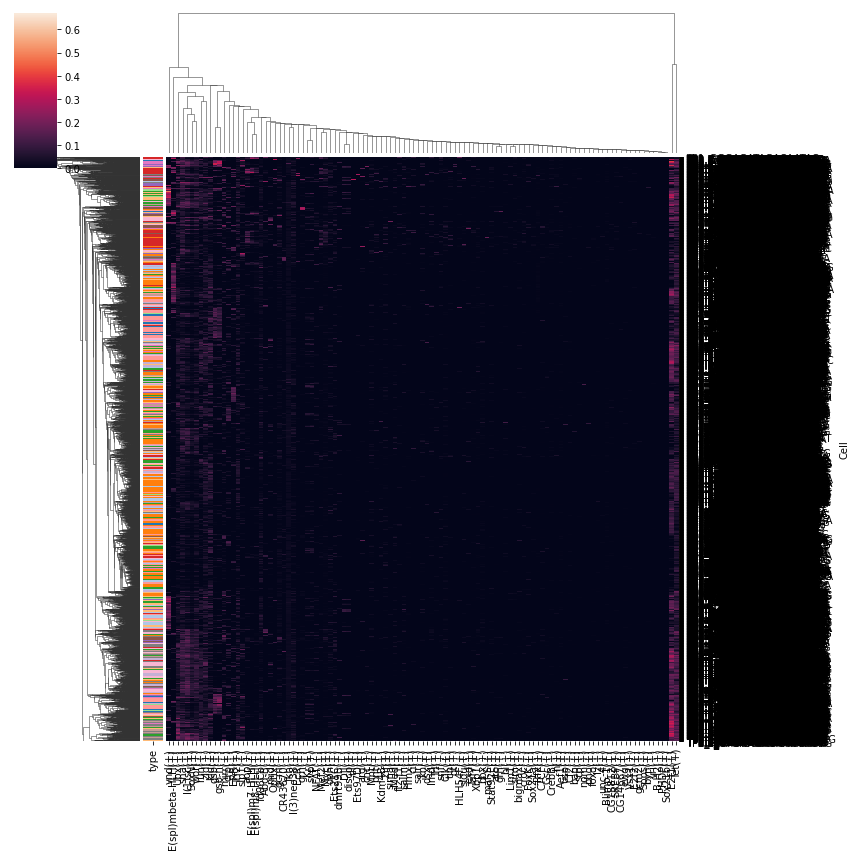

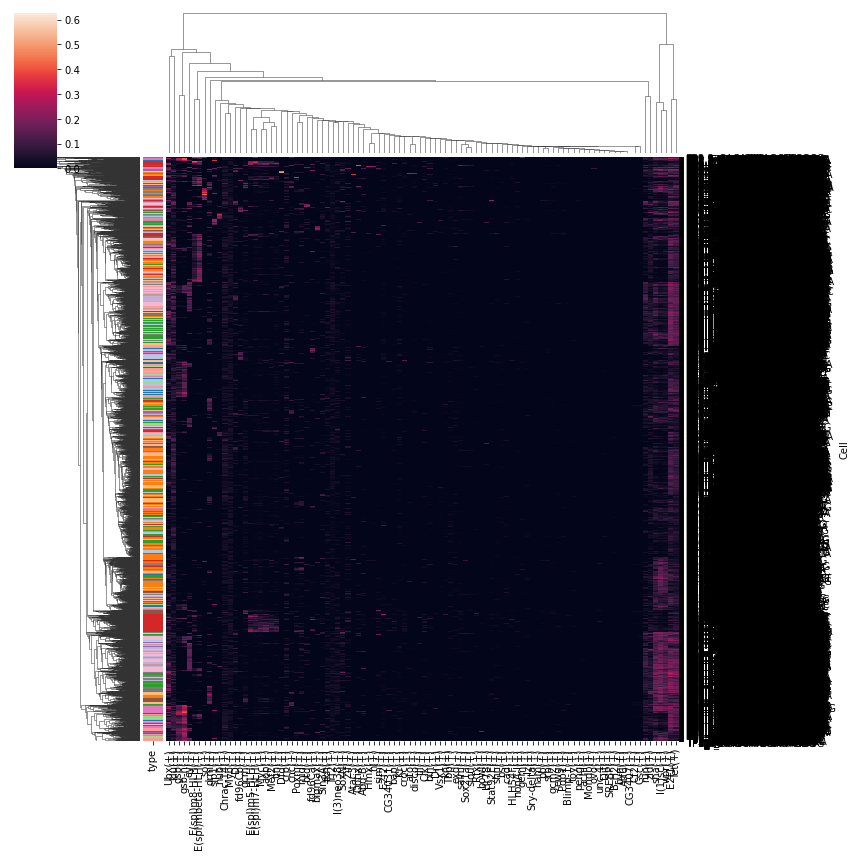

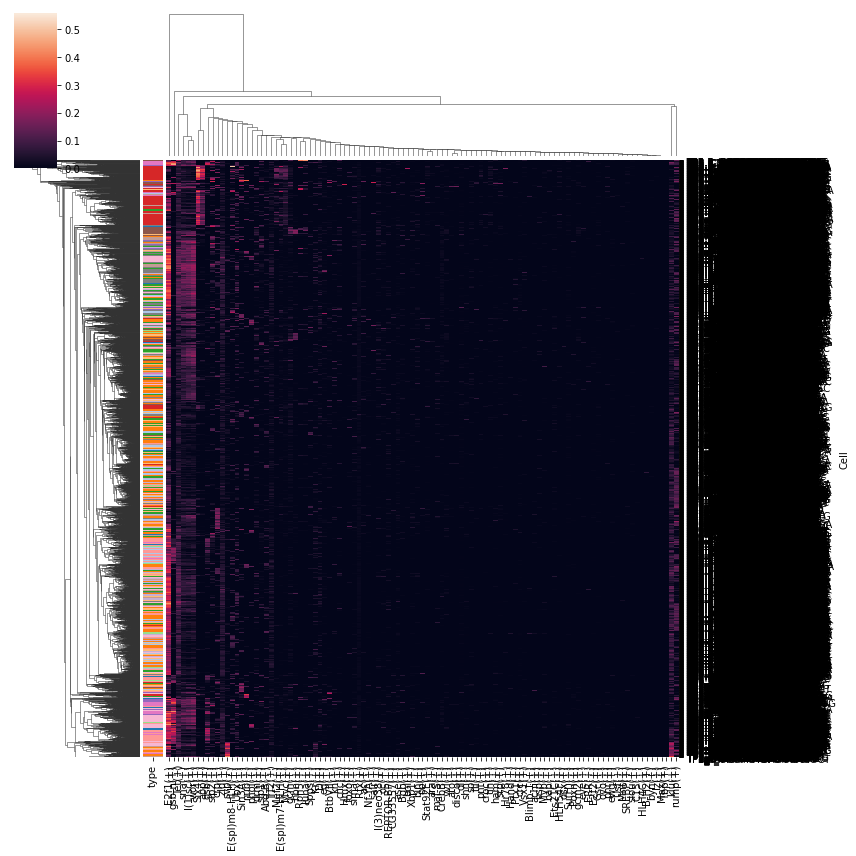

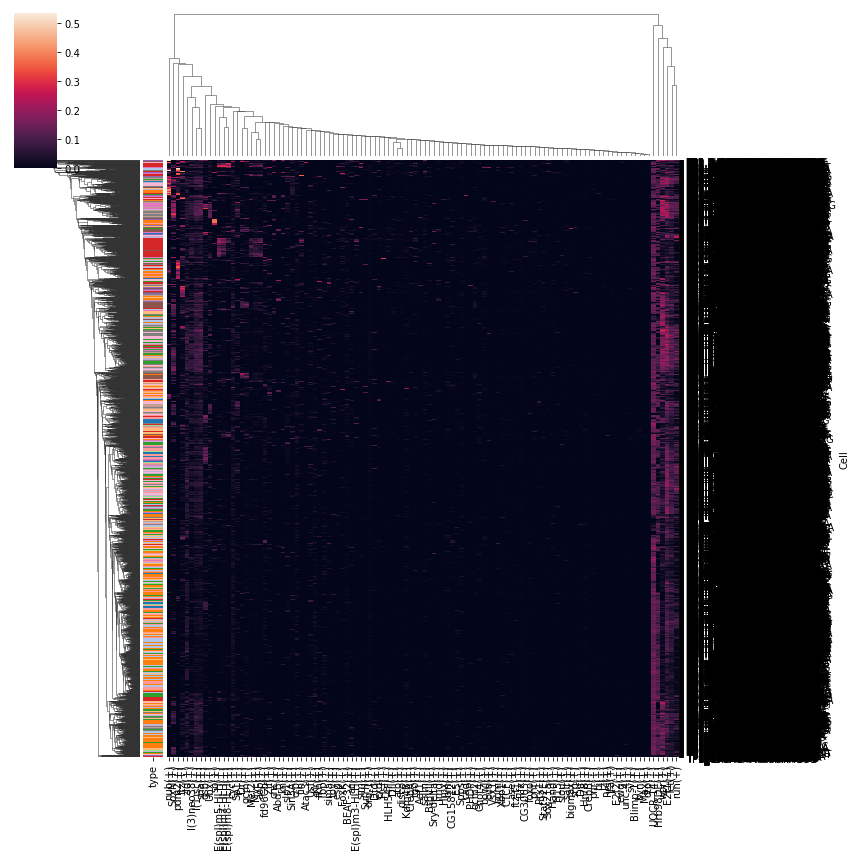

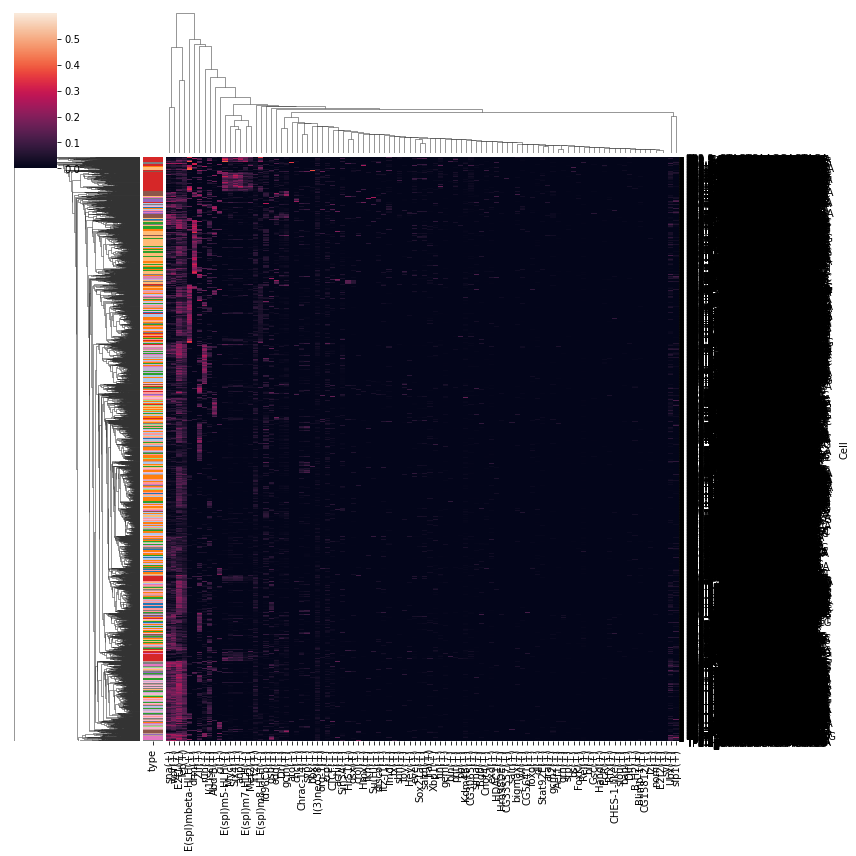

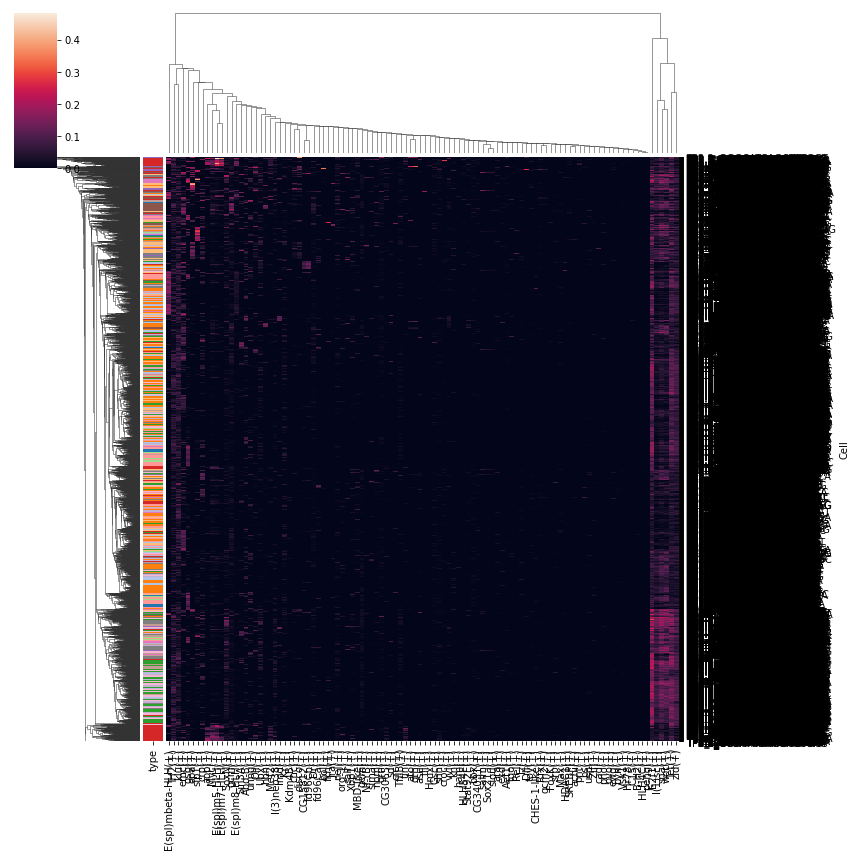

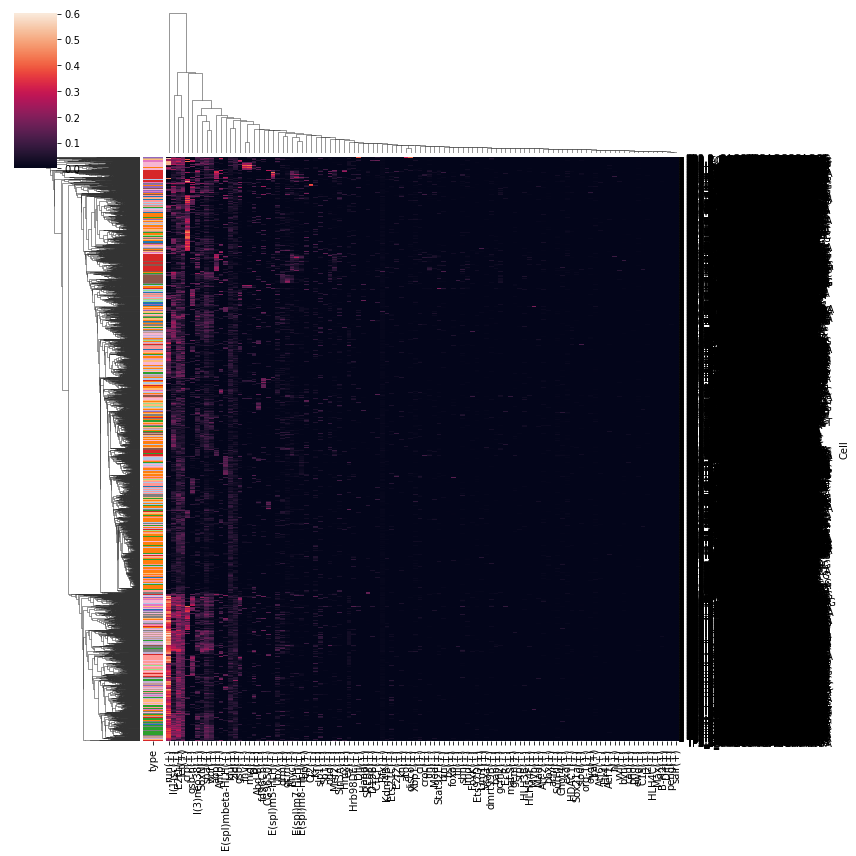

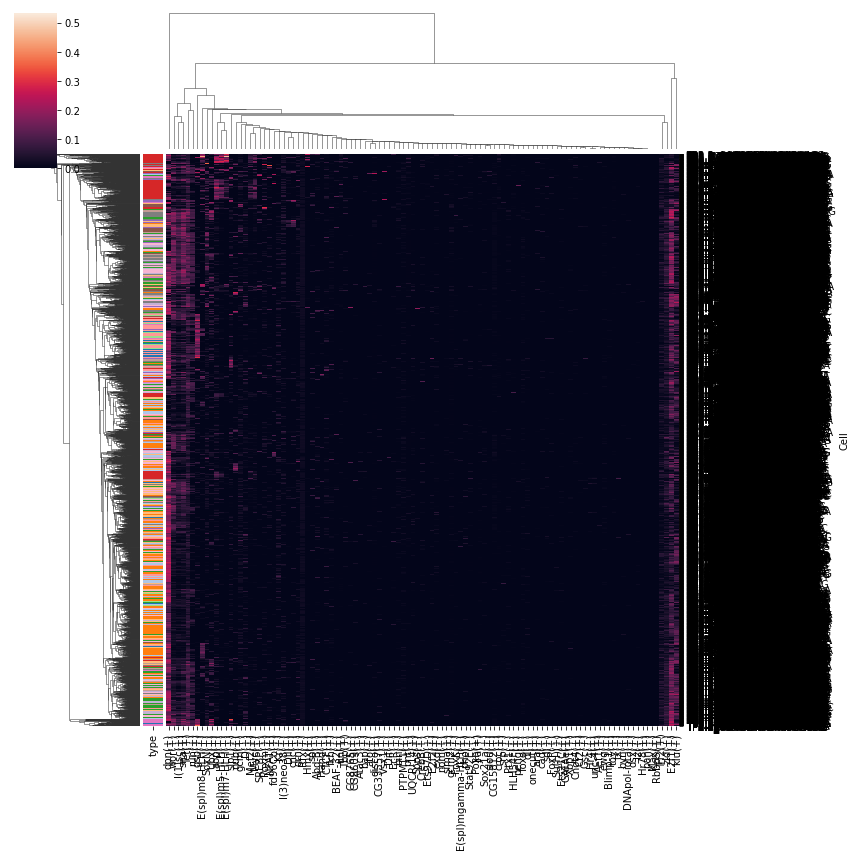

In [23]:
for folder in glob(results_dir_glob):
    auc_mtx = pd.read_csv(folder + "AUCell_mat.csv", index_col=0)
    # fix colors:
    row_colors = auc_mtx.merge(cell_colors, how='left', left_index=True, right_index=True).type
    # create heatmap abd save to results
    ax= sns.clustermap(auc_mtx, figsize=(12,12),yticklabels=True, xticklabels=True, row_colors=row_colors)
    ax.savefig(folder + "AUCell_heatmap_new.png")

## Heatmaps for top TFs for each run (AUCell score)


get cell types

In [ ]:
types_df = pd.read_csv("/home/dbarila/devo-grn/data/cell_type.csv", index_col=0)

create and save heatmaps as png for each run

In [ ]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("tab20", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

for folder in glob(results_dir_glob):
    auc_mtx_top80 = pd.read_csv(folder + "AUCell_mat_top80.csv", index_col=0)
    # fix colors:
    row_colors = auc_mtx_top80.merge(cell_colors, how='left', left_index=True, right_index=True).type
    # create heatmap abd save to results
    ax= sns.clustermap(auc_mtx_top80, figsize=(12,12),yticklabels=True, xticklabels=True, row_colors=row_colors)
    ax.savefig(folder + "top80_heatmap.png")

legend

In [13]:
from matplotlib.patches import Patch

In [14]:
handels = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handels, lut, title='cell type', framealpha=1)

NameError: name 'lut' is not defined

## AUCell mean score per cell type

In [ ]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("tab20", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

# auc_mtx = pd.read_csv("../results/run_01/top80_heatmap.png", index_col=0)
# types df : cell (index) | type
for folder in glob(results_dir_glob):
    auc_mtx_top80 = pd.read_csv(folder + "AUCell_mat_top80.csv", index_col=0)
    auc_type = auc_mtx_top80.merge(types_df, how='left', left_index=True, right_index=True)
    auc_type = auc_type.groupby("type").mean()
    # visuzlize 
    ax = sns.clustermap(auc_type, figsize=(12,12),yticklabels=True, xticklabels=True)
    ax.savefig(folder + "top80_heatmap_type.png")

## Binary representation (only to 80%)

In [ ]:
# from pyscenic tutorial https://pyscenic.readthedocs.io/en/latest/faq.html 
def plot_binarization(auc_mtx: pd.DataFrame, regulon_name: str, threshold: float, ax=None) -> None:
    """
    Plot the "binarization" process for the given regulon.

    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.
    """
    if ax is None:
        ax=plt.gca()
   
    auc_mtx[regulon_name].hist(ax=ax, bins='auto')  # originally bins are chosen to be 200

    ylim = ax.get_ylim()
    ax.plot([threshold]*2, ylim, 'r:')
    ax.set_ylim(ylim)
    # ax.set_xlim(0.12,0.35)
    ax.set_xlabel('AUC')
    ax.set_ylabel('# cells')
    ax.set_title(regulon_name)

In [ ]:
from pyscenic.binarization import binarize

In [ ]:
lut = dict(zip(types_df.type.unique(), sns.color_palette("tab20", len(types_df.type.unique()))))
cell_colors = types_df.type.map(lut)

for folder in glob(results_dir_glob):
    auc_mtx_top80 = pd.read_csv(folder + "AUCell_mat_top80.csv", index_col=0)
    binary = binarize(auc_mtx_top80)
    binary_aucell = binary[0]  # because binarize returns a touple of (df, Series of thresholds)
    row_colors = binary_aucell.merge(cell_colors, how='left', left_index=True, right_index=True).type
    ax = sns.clustermap(binary_aucell, figsize=(12,12),yticklabels=True, xticklabels=True, row_colors=row_colors)
    ax.savefig(folder + "top80_binary_heatmap.png")

----------

# No MG cells analysis

Filter the SC data from MG cells

-------

# transfer regulons to R 


In [3]:
final_reg_df = pd.read_csv("/Users/danabarilan/Documents/forMasters/Intenship/code/devo-grn/results/results_041023/final_regulons.csv")

In [10]:
final_reg_df['gene'] = final_reg_df['gene'].apply(lambda x: x.replace('[', '').replace(']', ''))


In [12]:
final_reg_df.to_csv("/Users/danabarilan/Documents/forMasters/Intenship/code/devo-grn/results/results_041023/final_regulons_forR.csv", index=False)